Looking at 32x32 patch dataset. Inter vs Intra
=============


In [8]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

Some functions

In [9]:
def display_image_rgb(data, width, height):
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    myshape = picture.shape
    picture = np.swapaxes(picture,0,1)
    picture = np.swapaxes(picture,1,2)    
    plt.imshow(picture)
    plt.axis("off")
    plt.show()    

def add_grid_lines(data, width, height, gridH, gridV):
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    myshape = picture.shape
    picture[:, 0:width:gridH, :] = 0
    picture[:, :, 0:height:gridV] = 0
    picture = picture.reshape((width*height*3), )
    return picture

    


    
def display_image_yuv(data, width, height):
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    myshape = picture.shape
    picture = picture[0]
    #plt.imshow(picture, cmap="hot")
    plt.imshow(picture, cmap="gray")
    plt.axis("off")
    plt.show()    

def thresholdAndRound(y):
    maxn = 255
    minn = 0
    y[y > maxn] = maxn
    y[y < minn] = minn
    y = np.around(y,0)
    return y

def convertToBytes(y):
    y = np.asarray(y, 'u1')
    return y


#Note that this function takes as input a planar RGB image
# It returns planar YUV4:4:4 (it's not common but it can be downsampled to 4:2:0)
def planarRGB_2_planarYUV(data, width, height):
    #print("in planarRGB_2_planarYUV")
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    r = np.array(picture[0])
    g = np.array(picture[1])
    b = np.array(picture[2])
    #print("orig R:" + str(r[0]))
    #print("orig G:" + str(g[0]))
    #print("orig B:" + str(b[0]))

    y = np.array(0.299*r + 0.587*g + 0.114*b)
    y = thresholdAndRound(y)
    u = ((b-y)*0.564) + delta
    v = ((r-y)*0.713) + delta
    
    #print("orig Y:" + str(y[0]))
    #print("orig U:" + str(u[0]))
    #print("orig V:" + str(v[0]))

    y = thresholdAndRound(y)
    u = thresholdAndRound(u)
    v = thresholdAndRound(v)
    y = convertToBytes(y)
    u = convertToBytes(u)
    v = convertToBytes(v)
    
    yuv = np.concatenate((y,u,v), axis = 0)
    yuv = yuv.reshape((width*height*3), )

    #print(y)
    #print(v)

    return yuv

def YUV444_2_YUV420(data, width, height):
    from scipy import signal
    #print("YUV444_2_YUV420")
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]

    #shape = u.shape
    #print("The old shape of u: "+ str(shape))
    #print(u)

    kernel = np.array([[1,1,0],
                       [1,1,0],
                       [0,0,0]]) 

    # Perform 2D convolution with input data and kernel 
    u = signal.convolve2d(u, kernel, mode='same')/kernel.sum()
    u = u[::2, ::2].copy()
    v = signal.convolve2d(v, kernel, mode='same')/kernel.sum()
    v = v[::2, ::2].copy()
    
    y = y.flatten()
    u = u.flatten()
    v = v.flatten()
    
    #shape = u.shape
    #print("The new shape of u: "+ str(shape))
    yuv = np.concatenate([y,u,v])
    return yuv

def YUV420_2_YUV444(data, width, height):
    from scipy import signal
    print("YUV420_2_YUV444")
    picture = np.array(data)
    picSize = width*height
    #picture = pic_planar.reshape(3, width, height)
    y = np.array(picture[0:picSize])
    
    u = np.array(picture[picSize:(picSize*5/4)])
    u = u.reshape((width/2), (height/2))
    #print("The old shape of u: "+ str(u.shape))
    #print(u)             
    u = np.repeat(u, 2, axis=0)
    #print("The new shape of u: "+ str(u.shape))
    #print(u)
    u = np.repeat(u, 2, axis=1)
    #print("The new shape of u: "+ str(u.shape))
    #print(u)

    v = np.array(picture[(picSize*5/4):])
    v = v.reshape((width/2), (height/2))
    #print("The old shape of v: "+ str(v.shape))
    #print(v)             
    v = np.repeat(v, 2, axis=0)
    #print("The new shape of v: "+ str(v.shape))
    #print(u)
    v = np.repeat(v, 2, axis=1)
    #print("The new shape of v: "+ str(v.shape))
    #print(v)


    y = y.flatten()
    u = u.flatten()
    v = v.flatten()
    
    #shape = u.shape
    #print("The new shape of u: "+ str(shape))
    yuv = np.concatenate([y,u,v])
    return yuv



    

# planar YUV 4:4:4 to rgb
def planarYUV_2_planarRGB(data, width, height):
    #print("in planarYUV_2_planarRGB")
    maxn = 255
    minn = 0
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]
    
    #print("recon Y:" + str(y[0]))
    #print("recon U:" + str(u[0]))
    #print("recon V:" + str(v[0]))

    
    r = y + 1.403 * (v-delta)
    g = y - (0.714 * (v-delta)) - (0.344 * (u-delta)) 
    b = y + 1.773 * (u-delta)

    #r = y + 1.13983 * v
    #g = y - (0.58060 * v) - (0.39465 * u) 
    #b = y + (2.03211 * u)


    r = thresholdAndRound(r)
    r = convertToBytes(r)
    g = thresholdAndRound(g)
    g = convertToBytes(g)
    b = thresholdAndRound(b)
    b = convertToBytes(b)
    #print("Reconstructed r:" + str(r[0]))
    #print("Reconstructed g:" + str(g[0]))
    #print("Reconstructed b:" + str(b[0]))

    rgb = np.concatenate((r,g,b), axis = 0)
    rgb = rgb.reshape((width*height*3), )
    return rgb

def quantiseUV(data, width, height):
    numLevels = 16
    q = 256/numLevels
    x = np.linspace(0, 10, 1000)
    
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]
    
    u = q * np.round(u/q)
    v = q * np.round(v/q)

    yuv = np.concatenate((y,u,v), axis = 0)
    yuv = yuv.reshape((width*height*3), )
    return yuv

def saveToFile(data, filename):
    datayuv = np.asarray(data, 'u1')
    yuvByteArray = bytearray(datayuv)
    mylen = len(yuvByteArray)
    yuvFile = open(filename, "wb")
    yuvFile.write(yuvByteArray)
    yuvFile.close()

def appendToFile(data, filename):
    datayuv = np.asarray(data, 'u1')
    yuvByteArray = bytearray(datayuv)
    mylen = len(yuvByteArray)
    #print("Adding bytes to file: "+str(mylen))
    yuvFile = open(filename, "ab")
    yuvFile.write(yuvByteArray)
    yuvFile.close()
    
def doubleImage(data, width, height):
    doubleW = width*2
    doubleH = height*2
    import PIL
    rgbframe = planarYUV_2_planarRGB(data, height, width)
    test = np.asarray(rgbframe, 'u1')
    pictureA = test.reshape(3, height, width)
    pictureA = np.swapaxes(pictureA,0,1)
    pictureA = np.swapaxes(pictureA,1,2)
    pictureA = np.ndarray.flatten(pictureA)
    imageA = Image.frombytes('RGB', (height, width), pictureA)
    #imgOrig = imageA
    
    imageA = imageA.resize((doubleH,doubleW), PIL.Image.LANCZOS)
    #display(imageA)
    #imageB = imgOrig.resize((doubleH,doubleW), PIL.Image.BICUBIC)
    #display(imageB)

    pixels = list(imageA.getdata())
    pixels = np.asarray(pixels, 'u1')
    pixels = pixels.reshape(doubleH, doubleW, 3)
    pixels = np.swapaxes(pixels,2,1)
    pixels = np.swapaxes(pixels,1,0)
    pixels = pixels.flatten()
    yuvpixels = planarRGB_2_planarYUV(pixels, doubleH, doubleW)
    #pixels = pixels.flatten()
    return yuvpixels




Get the dictionaries and look at the pictures.

(302581251,)
There are 1539 patches in the file
Shape of allTheData array: (1539, 196609)
Shape of labels array: (1539,)
The index of the image is 0, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is tampered


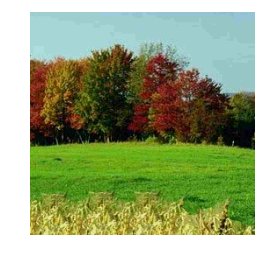

shape of rgb frame: (196608,)


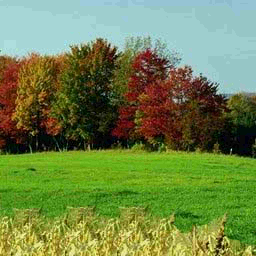

The index of the image is 1, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is authentic


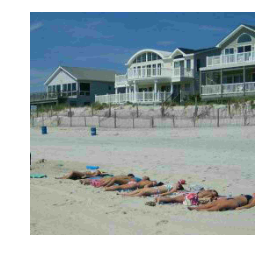

shape of rgb frame: (196608,)


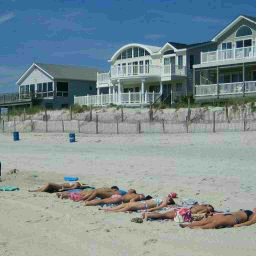

The index of the image is 2, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is tampered


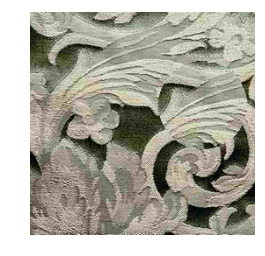

shape of rgb frame: (196608,)


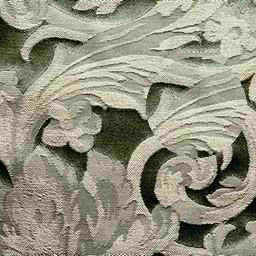

The index of the image is 3, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is tampered


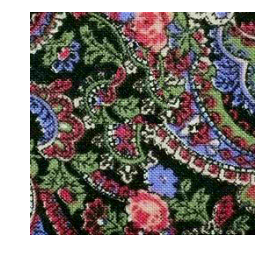

shape of rgb frame: (196608,)


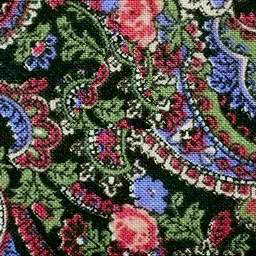

The index of the image is 42, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is authentic


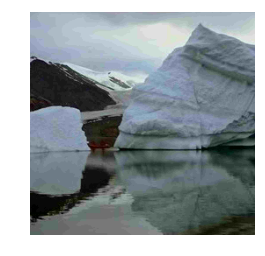

shape of rgb frame: (196608,)


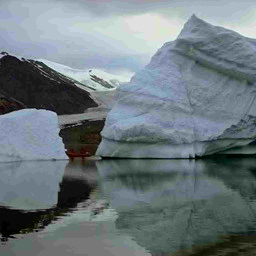

The index of the image is 43, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is authentic


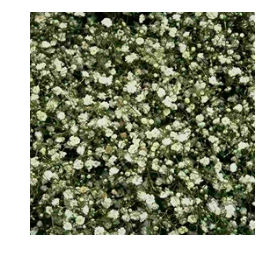

shape of rgb frame: (196608,)


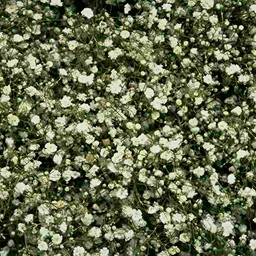

The index of the image is 44, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is tampered


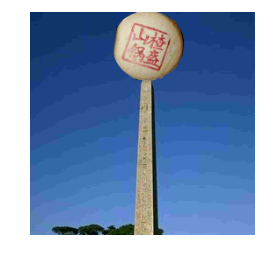

shape of rgb frame: (196608,)


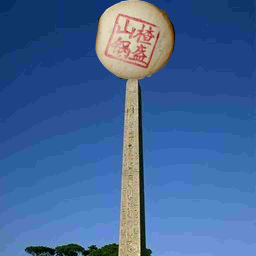

The index of the image is 45, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is tampered


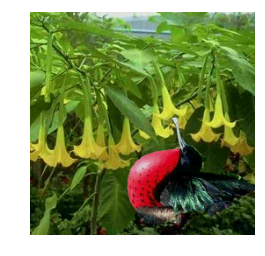

shape of rgb frame: (196608,)


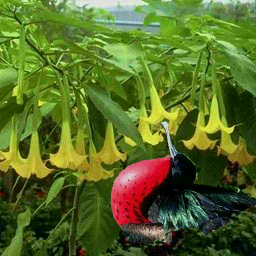

In [12]:
import matplotlib.pyplot as plt
import random
from PIL import Image

data_folder = '/Volumes/LaCie/data/CASIA1/test_crop.bin'
data_folder = '/Volumes/LaCie/data/CASIA1/train_crop.bin'



folderFormat = 'yuv'

width = 256
height = 256
channels = 3
pixel_depth = 8


#num_cases_per_batch = 10000
num_cases_per_batch = 2

label_names = ['authentic', 'tampered']

    
f = open(data_folder, "rb")
allTheData = np.fromfile(f, 'u1')
print(allTheData.shape)
recordSize = (width * height * channels) + 1
num_cases_per_batch = allTheData.shape[0] / recordSize
print("There are {} patches in the file".format(num_cases_per_batch))



allTheData = allTheData.reshape(num_cases_per_batch, recordSize)
data_labels = allTheData[:, 0].copy()
data_array = allTheData[:, 1:].copy()

print("Shape of allTheData array: {}".format(allTheData.shape))
print("Shape of labels array: {}".format(data_labels.shape))


index = random.randint(0,num_cases_per_batch)
index = 0
indexes = [0, 1, 2, 3, 42, 43, 44, 45]

for i in indexes:
    index = i
    print('The index of the image is {}, data shape {}'.format(index, allTheData.shape))
    print(data_folder)


    # Try scaling it up a bit
    scaleUp = False
    if scaleUp == True:
        myframe = data_array[index]
        myframe = myframe * pixel_depth
        myframe = doubleImage(myframe, height, width)
        rgbframe = planarYUV_2_planarRGB(myframe, (height*2), (width*2))
        print("displaying double sized frame")
        display_image_rgb(rgbframe, (height*2), (width*2))
    #end scaling it

    print("The label is {}".format(label_names[data_labels[index]]))
    test_data_array = data_array

    filename = "patch{}_mbmode_{}.png".format(index, label)

    if folderFormat == 'rgb':
        rgbframe = test_data_array[index]
    elif folderFormat == 'yuv':
        frame = test_data_array[index]
        frame = frame * pixel_depth
        rgbframe = planarYUV_2_planarRGB(frame, height, width)

    #rgbframe = add_grid_lines(rgbframe, 32, 32, 8, 8)

    display_image_rgb(rgbframe, height, width)
    print("shape of rgb frame: {}".format(rgbframe.shape))
    test = np.asarray(rgbframe, 'u1')
    pictureA = test.reshape(3, width, height)
    pictureA = np.swapaxes(pictureA,0,1)
    pictureA = np.swapaxes(pictureA,1,2)
    pictureA = np.ndarray.flatten(pictureA)

    imageA = Image.frombytes('RGB', (height, width), pictureA)
    display(imageA)
    imageA.save(filename, "PNG")




Split into test and train
--------------------------

In [5]:
print("Shape of allTheData array: {}".format(allTheData.shape))
print("Shape of labels array: {}".format(data_labels.shape))

def shuffleFile(infileName, outfileName, recordSize):
    with open(infileName, "rb") as f:
        allData = np.fromfile(f, 'u1')
    print(allData.shape)
    num_cases_per_batch = allData.shape[0] / recordSize
    print("There are {} records in the file".format(num_cases_per_batch))
    allData = allData.reshape(num_cases_per_batch, recordSize)
    # Shuffle it twice
    np.random.shuffle(allData)
    np.random.shuffle(allData)
    
    # write it out to a binary file
    data = allData.flatten()
    data = np.asarray(data, 'u1')
    myByteArray = bytearray(data)
    mylen = len(myByteArray)
    #print("Adding bytes to file: "+str(mylen))
    with open(outfileName, "wb") as outFile:
        outFile.write(myByteArray)
    
inFileName = '/Users/pam/Documents/data/h264/patches/patches_qcif_all.bin'
outFileName = '/Users/pam/Documents/data/h264/patches/patches_qcif_all_shuffled.bin'
shuffleFile(inFileName, outFileName, recordSize)

inFileName = '/Users/pam/Documents/data/h264/patches/patches_cif_all.bin'
outFileName = '/Users/pam/Documents/data/h264/patches/patches_cif_all_shufffled.bin'
shuffleFile(inFileName, outFileName, recordSize)



Shape of allTheData array: (20422, 3073)
Shape of labels array: (20422,)
(62756806,)
There are 20422 records in the file
(52222562,)
There are 16994 records in the file


-----------
Processing the log file produced when the dataset with constant quant was produced
-----------

In [7]:
datasetLogFileName = '/Volumes/LaCie/data/CIFAR-10/cifar_data_constantQuant/log_batches1to5andtest.txt'
#datasetLogFileName = '/Users/pam/Documents/data/CIFAR-10/cifar_data_constantBitrate/log.txt'


#logEntries = np.genfromtxt (datasetLogFileName, delimiter=",")
#print("the shape of the log file {}".format(logEntries.shape))
with open(datasetLogFileName, 'r') as l:
    allTheLogData = l.read()
    
textLines = allTheLogData.splitlines()
textLines = textLines[2:]
dataEntries = []

print(textLines[0])
for textLine in textLines:
    textLine = textLine.replace("%", '')
    #print(textLine)
    values = textLine.split(', ')
    frameSize = float(values[-3])
    indyFrameSize = float(values[-3])
    if values[4] == 'I':
        indyFrameSize = float(values[-3])
    elif values[4] == 'P':
        indyFrameSize = float(values[-2])
    else:
        indyFrameSize = float(values[-1])
    if values[4] == 'I':
        frameSize = float(values[-3])
    elif values[4] == 'P':
        frameSize = (float(values[-2]) + float(values[-3]))/2
    else:
        frameSize = (float(values[-1]) + float(values[-2]) + float(values[-3]))/3
    
    entry = values[:7]
    #print(entry)

    entry.append(frameSize)
    entry.append(indyFrameSize)
    entry[2] = float(entry[2])
    entry[3] = float(entry[3])
    entry[5] = float(entry[5])
    entry[6] = float(entry[6])
    dataEntries.append(entry)
        

data_batch_1.bin, frog, 10, 0, I, 39.1234706446, 0.970789630032, 2016, 596, 190


In [8]:
print(dataEntries[0])
quantValues = [10, 25, 37, 41, 46, 50]
#quantValues = [200000, 100000, 50000, 35000, 20000, 10000]

frameNums = [0, 2, 3, 6]
qfEntries = []
for qIdx, quantValue in enumerate(quantValues):
    qfEntriesfIdx = []
    for fIdx, frameNum in enumerate(frameNums):
        qfEntriesfIdx.append([row[5:] for row in dataEntries if quantValue == row[2] and frameNum == row[3]])
    qfEntries.append(qfEntriesfIdx)

#for qIdx, quantValue in enumerate(quantValues):
#    for fIdx, frameNum in enumerate(frameNums):
#        print("The entries for f{} q{}: {}".format(frameNum, quantValue, qfEntries[qIdx][fIdx][0:100]))



['data_batch_1.bin', 'frog', 10.0, 0.0, 'I', 39.1234706446, 0.970789630032, 2016.0, 2016.0]


the new array shape (6, 4, 60000, 4)
[  3.91234706e+01   9.70789630e-01   2.01600000e+03   2.01600000e+03]
the means array shape (6, 4, 4)
Frameno: 0 Quant: 10 frameSize: 1881.43625
Frameno: 0 Quant: 25 frameSize: 1243.88351667
Frameno: 0 Quant: 37 frameSize: 951.9057
Frameno: 0 Quant: 41 frameSize: 893.366083333
Frameno: 0 Quant: 46 frameSize: 840.457066667
Frameno: 0 Quant: 50 frameSize: 807.326916667
Frameno: 2 Quant: 10 frameSize: 155.967883333
Frameno: 2 Quant: 25 frameSize: 97.5152166667
Frameno: 2 Quant: 37 frameSize: 72.44855
Frameno: 2 Quant: 41 frameSize: 70.0900166667
Frameno: 2 Quant: 46 frameSize: 64.8417166667
Frameno: 2 Quant: 50 frameSize: 50.4020333333
Frameno: 3 Quant: 10 frameSize: 654.506
Frameno: 3 Quant: 25 frameSize: 343.4103
Frameno: 3 Quant: 37 frameSize: 198.547683333
Frameno: 3 Quant: 41 frameSize: 168.432833333
Frameno: 3 Quant: 46 frameSize: 140.216933333
Frameno: 3 Quant: 50 frameSize: 120.755216667
Frameno: 6 Quant: 10 frameSize: 654.506
Frameno: 6 Quant:

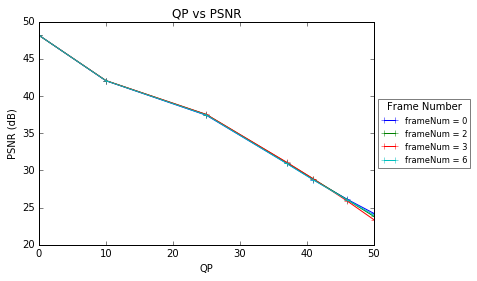

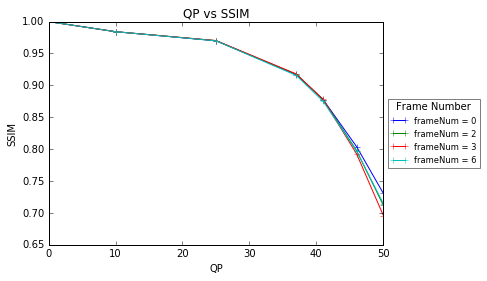

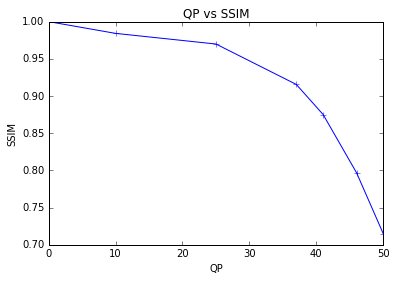

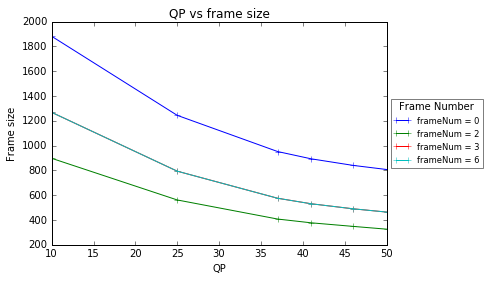

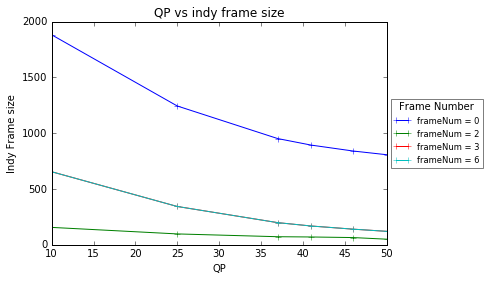

In [9]:
#print(qfEntries[0][0][3])

PSNRslot = 5
SSIMslot = 6
indyFrameSizeslot = 7
FrameSizeslot = 8


#print(qfEntries[0][0][0][5:8])
#temp = qfEntries[:][:][:][5:8]
#print(temp)


redQfEntries = np.asarray(qfEntries)

print("the new array shape {}".format(redQfEntries.shape))
print(redQfEntries[0][0][0])



qfEntriesMeans = np.mean(redQfEntries, axis=2)
print("the means array shape {}".format(qfEntriesMeans.shape))

    
#print("the means")
#print(qfEntriesMeans[0][0])
#for qIdx, quantValue in enumerate(quantValues):
#    for fIdx, frameNum in enumerate(frameNums):
#        print("qIdx {}, fIdx {}".format(qIdx, fIdx))
#        print("For quant {} and frame number {} means {:.2f} {:.2f} {:.2f}".format(quantValue, frameNum, qfEntriesMeans[qIdx][fIdx][0], qfEntriesMeans[qIdx][fIdx][1], qfEntriesMeans[qIdx][fIdx][2]))



fig1 = plt.figure()
for fIdx, frameNum in enumerate(frameNums):
    plt.xlabel('QP')
    plt.ylabel('PSNR (dB)')
    plt.title('QP vs PSNR')
    averagePSNR = [48.16]
    averageSSIM = [1.0]
    averageFrameSize = []
    averageIndyFrameSize = []
    for qIdx, quantValue in enumerate(quantValues):
        averagePSNR.append(qfEntriesMeans[qIdx][fIdx][0])
        averageSSIM.append(qfEntriesMeans[qIdx][fIdx][1])
        averageFrameSize.append(qfEntriesMeans[qIdx][fIdx][2])
        averageIndyFrameSize.append(qfEntriesMeans[qIdx][fIdx][3])
    myQuants = [0] + quantValues
    plt.plot( myQuants, averagePSNR, '-+', label=('frameNum = {}'.format(frameNum)))
plt.legend(title="Frame Number", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('QP_vs_PSNR.png', bbox_inches='tight')


fig2 = plt.figure()
for fIdx, frameNum in enumerate(frameNums):
    plt.xlabel('QP')
    plt.ylabel('SSIM')
    plt.title('QP vs SSIM')
    averagePSNR = [48.16]
    averageSSIM = [1.0]
    averageFrameSize = []
    averageIndyFrameSize = []
    for qIdx, quantValue in enumerate(quantValues):
        averagePSNR.append(qfEntriesMeans[qIdx][fIdx][0])
        averageSSIM.append(qfEntriesMeans[qIdx][fIdx][1])
        averageFrameSize.append(qfEntriesMeans[qIdx][fIdx][2])
        averageIndyFrameSize.append(qfEntriesMeans[qIdx][fIdx][3])
    myQuants = [0] + quantValues
    plt.plot( myQuants, averageSSIM, '-+', label=('frameNum = {}'.format(frameNum)))
plt.legend(title="Frame Number", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('QP_vs_SSIM.png', bbox_inches='tight')

fig2b = plt.figure()
frameNum = 0
plt.xlabel('QP')
plt.ylabel('SSIM')
plt.title('QP vs SSIM')
averagePSNR = [48.16]
averageSSIM = [1.0]
averageFrameSize = []
averageIndyFrameSize = []
for qIdx, quantValue in enumerate(quantValues):
    averagePSNR.append(qfEntriesMeans[qIdx][fIdx][0])
    averageSSIM.append(qfEntriesMeans[qIdx][fIdx][1])
    averageFrameSize.append(qfEntriesMeans[qIdx][fIdx][2])
    averageIndyFrameSize.append(qfEntriesMeans[qIdx][fIdx][3])
myQuants = [0] + quantValues
#myQuants = quantValues
plt.plot( myQuants, averageSSIM, '-+', label=('frameNum = {}'.format(frameNum)))
#plt.legend(title="Frame Number", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('QP_vs_SSIM_f0.png', bbox_inches='tight')

fig3 = plt.figure()
for fIdx, frameNum in enumerate(frameNums):
    plt.xlabel('QP')
    plt.ylabel('Frame size')
    plt.title('QP vs frame size')
    averagePSNR = []
    averageSSIM = []
    averageFrameSize = []
    averageIndyFrameSize = []
    for qIdx, quantValue in enumerate(quantValues):
        averagePSNR.append(qfEntriesMeans[qIdx][fIdx][0])
        averageSSIM.append(qfEntriesMeans[qIdx][fIdx][1])
        averageFrameSize.append(qfEntriesMeans[qIdx][fIdx][2])
        averageIndyFrameSize.append(qfEntriesMeans[qIdx][fIdx][3])
    plt.plot( quantValues, averageFrameSize, '-+', label=('frameNum = {}'.format(frameNum)))
plt.legend(title="Frame Number", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('QP_vs_frame_size.png', bbox_inches='tight')


fig4 = plt.figure()
for fIdx, frameNum in enumerate(frameNums):
    plt.xlabel('QP')
    plt.ylabel('Indy Frame size')
    plt.title('QP vs indy frame size')
    averagePSNR = []
    averageSSIM = []
    averageFrameSize = []
    averageIndyFrameSize = []
    for qIdx, quantValue in enumerate(quantValues):
        averagePSNR.append(qfEntriesMeans[qIdx][fIdx][0])
        averageSSIM.append(qfEntriesMeans[qIdx][fIdx][1])
        averageFrameSize.append(qfEntriesMeans[qIdx][fIdx][2])
        averageIndyFrameSize.append(qfEntriesMeans[qIdx][fIdx][3])
        print("Frameno: {} Quant: {} frameSize: {}".format(frameNum, quantValue, qfEntriesMeans[qIdx][fIdx][3]))
    plt.plot( quantValues, averageIndyFrameSize, '-+', label=('frameNum = {}'.format(frameNum)))
plt.legend(title="Frame Number", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('QP_vs_indy_frame_size.png', bbox_inches='tight')




---
Graph Plotting
---------

Let's look at plotting some graphs....

This first one is looking at constant quant.

---

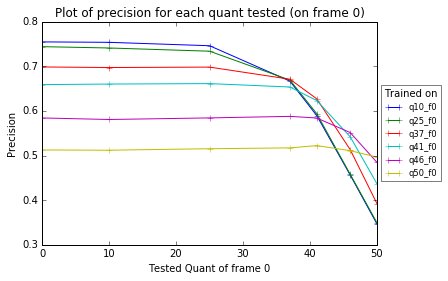

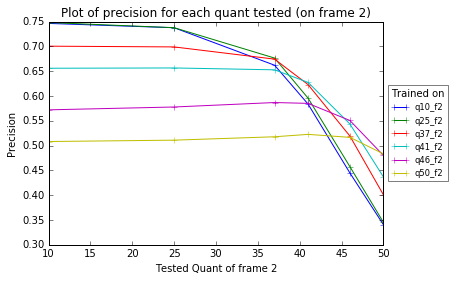

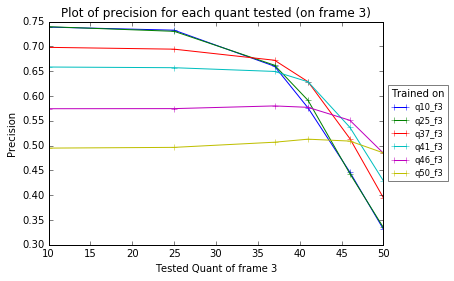

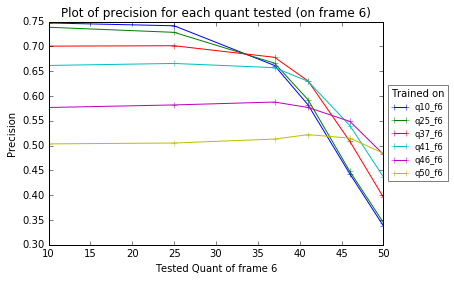

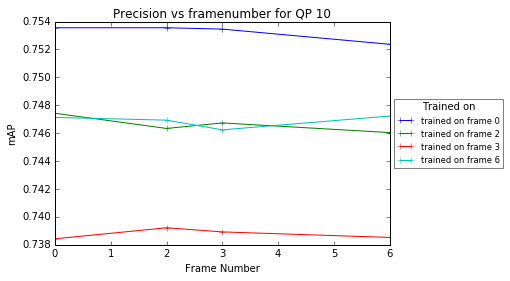

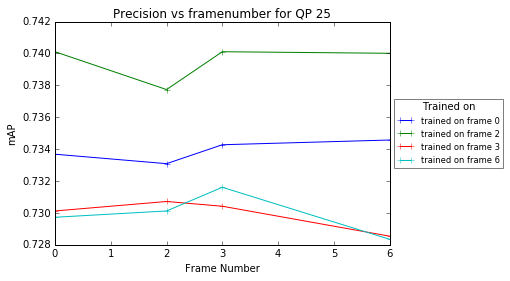

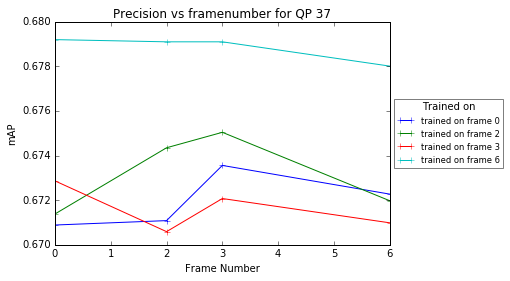

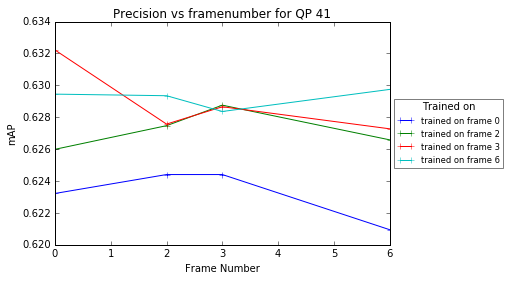

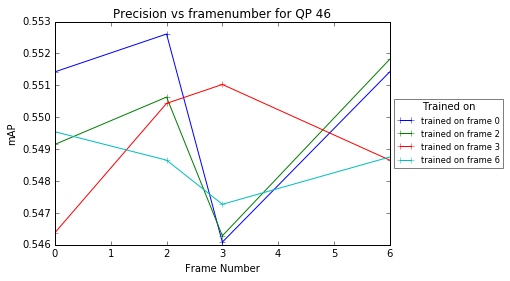

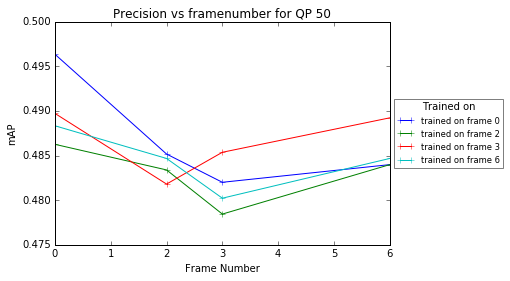

In [11]:
import matplotlib.pyplot as plt

plotDataName = '/Volumes/LaCie/data/CIFAR-10/test2/log_30ksteps_interlaced.txt'
#plotDataName = '/Users/pam/Documents/data/CIFAR-10/test3/log.txt'



with open(plotDataName, 'r') as f:
    allTheData = f.read()
    
textLines = allTheData.splitlines()
#trained, tested, result
dataArray = []
names = []
quants = [0]

for line in textLines:
    #print("Begin")
    #print(line)
    words = line.split()
    if words[0] == 'Evaluating':
        trainedOn = words[3].split('-')
        trainedOn = trainedOn[0]
        testedOn = words[1]
        precision = words[-1]
        
        trainedQuant = 0
        trainedFrame = -1
        temp = list(trainedOn)
        if trainedQuant == 'yuv':
            trainedQuant = 0
        if temp[0] == 'q':
            theNumbers = (temp[1], temp[2])
            theString = ''.join(theNumbers)
            trainedQuant = int(theString)
            if trainedQuant not in quants:
                quants.append(trainedQuant)
            if temp[4] == 'f':
                trainedFrame = int(temp[5])

        
        testedQuant = 0
        testedFrame = -1
        temp = list(testedOn)
        if testedOn == 'yuv':
            testedFrame = 0
        if temp[0] == 'q':
            theNumbers = (temp[1], temp[2])
            theString = ''.join(theNumbers)
            testedQuant = int(theString)
            if temp[4] == 'f':
                testedFrame = int(temp[5])

        
        dataEntry = [trainedOn, testedOn, trainedQuant, trainedFrame, testedQuant, testedFrame, precision]
        #print(dataEntry)
        dataArray.append(dataEntry)
        if trainedOn not in names:
            #print("adding: {}".format(trainedOn))
            names.append(trainedOn)
        
#print(names)
for fIdx, frameNum in enumerate(frameNums):
    fig1 = plt.figure()
    plt.xlabel('Tested Quant of frame {0}'.format(frameNum))
    plt.ylabel('Precision')
    plt.title('Plot of precision for each quant tested (on frame {0})'.format(frameNum))
    releventName = ('f{}'.format(frameNum))
    for nameIdx, name in enumerate(names):
        if releventName in name:
            plotVals = []
            quants = []
            for entry in dataArray:
                if entry[0] == name and entry[5] == frameNum:
                    quants.append(entry[4])
                    plotVals.append(entry[-1])
            #plt.plot( np.arange(0, len(plotVals), 1), plotVals, label=(name))
            plt.plot( quants, plotVals, '-+', label=(name))
    plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('Quant_vs_mAP_f{}.png'.format(frameNum), bbox_inches='tight')
    
releventName = ('f{}'.format(frameNum))
names = ['q10_', 'q25_', 'q37_', 'q41_', 'q46_', 'q50_']
#print(name)
for name in names:
    fig1b = plt.figure()
    frameNums = [0, 2, 3, 6]
    correctedName = name.replace('_', '')
    correctedName = correctedName.replace('q', '')
    plt.xlabel('Frame Number')
    plt.ylabel('mAP')
    plt.title('Precision vs framenumber for QP {}'.format(correctedName))
    for frame in frameNums:
        plotVals = []
        quants = []
        for entry in dataArray:
            if name in entry[0] and name in entry[1] and entry[3] == frame:
                quants.append(entry[5])
                plotVals.append(entry[-1])
        plt.plot( quants, plotVals, '-+', label=("trained on frame {}".format(frame)))
    plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('Precision(noAug)_vs_frameNo_forQP_.png'.format(correctedName), bbox_inches='tight')



And again but with data augmentation in the training

['yuv', 'y_quv', 'y_squv', 'interlaced', 'q10_f0', 'q10_f2', 'q10_f3', 'q10_f6', 'q25_f0', 'q25_f2', 'q25_f3', 'q25_f6', 'q37_f0', 'q37_f2', 'q37_f3', 'q37_f6', 'q41_f0', 'q41_f2', 'q41_f3', 'q41_f6', 'q46_f0', 'q46_f2', 'q46_f3', 'q46_f6', 'q50_f0', 'q50_f2', 'q50_f3', 'q50_f6']
0
10
25
37
41
46
50
0
10
25
37
41
46
50
0
10
25
37
41
46
50
0
10
25
37
41
46
50
0
10
25
37
41
46
50
0
10
25
37
41
46
50
0
10
25
37
41
46
50


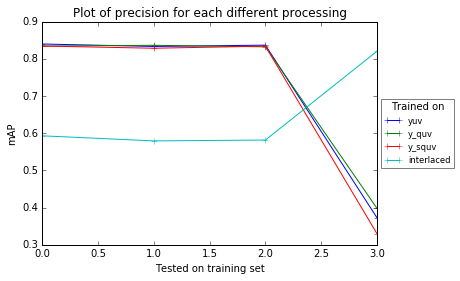

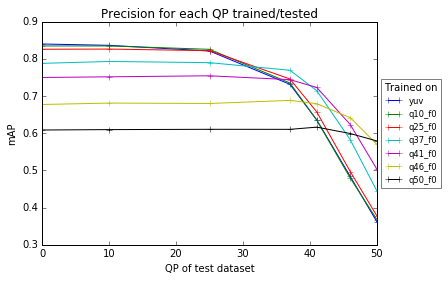

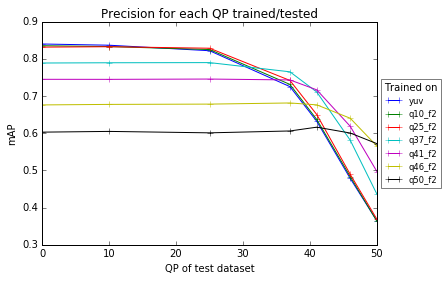

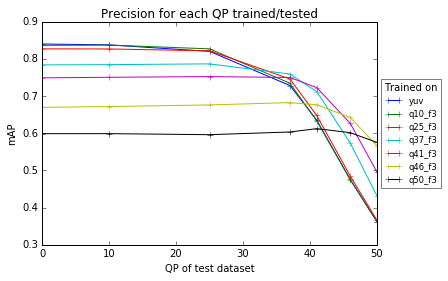

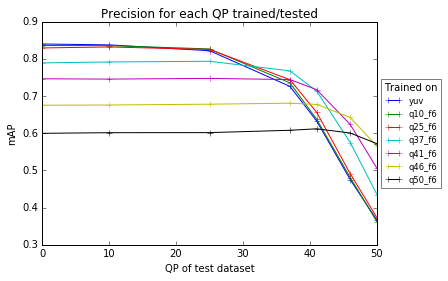

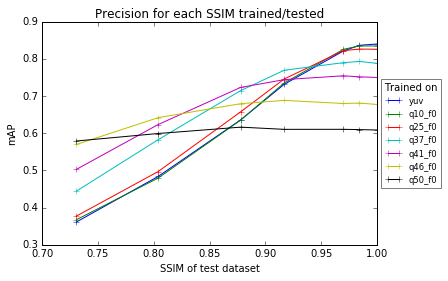

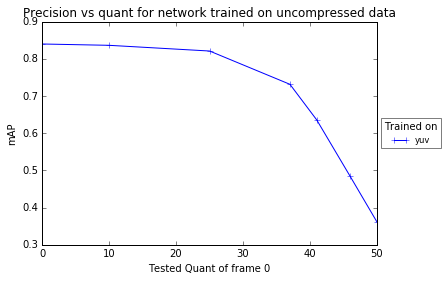

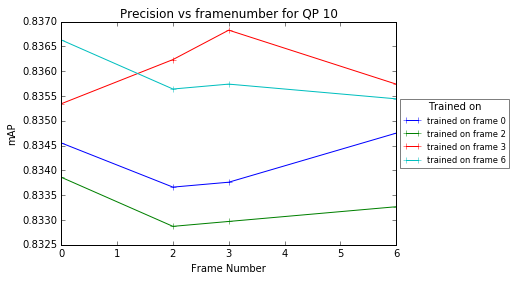

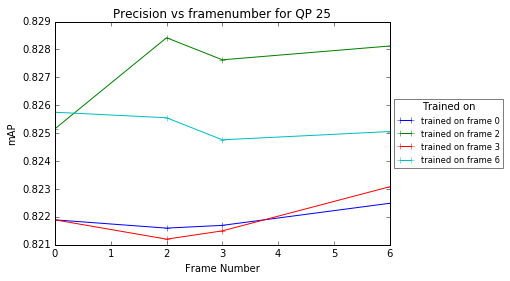

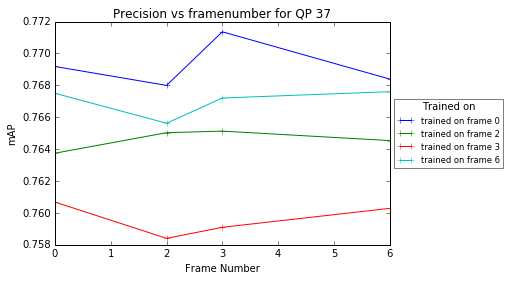

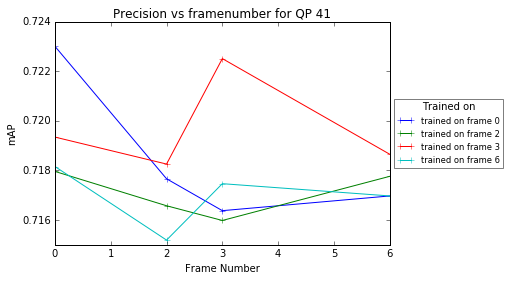

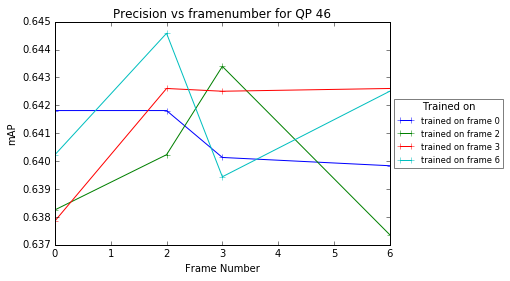

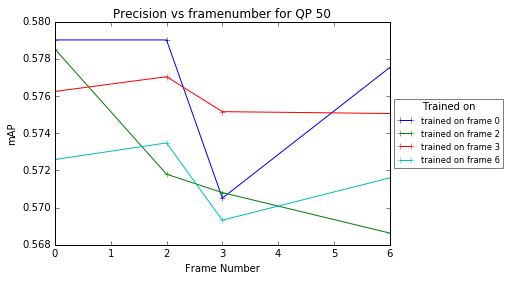

In [12]:
plotDataName = '/Volumes/LaCie/data/CIFAR-10/test3/log.txt'


with open(plotDataName, 'r') as f:
    allTheData = f.read()
    
textLines = allTheData.splitlines()
#trained, tested, result
dataArray = []
names = []
#names = ['yuv', 'y_squv', 'q10_', 'q25_', 'q37_', 'q41_', 'q46_', 'q50_']
quants = [0]

for line in textLines:
    #print("Begin")
    #print(line)
    words = line.split()
    if words[0] == 'Evaluating':
        trainedOn = words[3].split('-')
        trainedOn = trainedOn[0]
        testedOn = words[1]
        precision = words[-1]
        
        trainedQuant = 0
        trainedFrame = -1
        temp = list(trainedOn)
        if trainedQuant == 'yuv':
            trainedQuant = 0
        if temp[0] == 'q':
            theNumbers = (temp[1], temp[2])
            theString = ''.join(theNumbers)
            trainedQuant = int(theString)
            if trainedQuant not in quants:
                quants.append(trainedQuant)
            if temp[4] == 'f':
                trainedFrame = int(temp[5])

        
        testedQuant = 0
        testedFrame = -1
        temp = list(testedOn)
        if testedOn == 'yuv':
            testedFrame = 0
        if temp[0] == 'q':
            theNumbers = (temp[1], temp[2])
            theString = ''.join(theNumbers)
            testedQuant = int(theString)
            if temp[4] == 'f':
                testedFrame = int(temp[5])

        
        dataEntry = [trainedOn, testedOn, trainedQuant, trainedFrame, testedQuant, testedFrame, precision]
        #print(dataEntry)
        dataArray.append(dataEntry)
        if trainedOn not in names:
            #print("adding: {}".format(trainedOn))
            names.append(trainedOn)
        
print(names)
alternativeNames = names[0:4]
datasetNames = names
#print(alternativeNames)
fig0 = plt.figure()
plt.xlabel('Tested on training set'.format(frameNum))
plt.ylabel('mAP')
plt.title('Plot of precision for each different processing')
for nameIdx, name in enumerate(alternativeNames):
    plotVals = []
    quants = []
    for entry in dataArray:
        #print(entry)
        if entry[0] == name and entry[1] in alternativeNames:
            quants.append(entry[1])
            plotVals.append(entry[-1])
    #print(quants)
    
    plt.plot( np.arange(len(quants)), plotVals, '-+', label=(name))
plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('Quant_vs_mAP_types.png'.format(frameNum), bbox_inches='tight')


for fIdx, frameNum in enumerate(frameNums):
    fig1 = plt.figure()
    plt.xlabel('QP of test dataset')
    plt.ylabel('mAP')
    plt.title('Precision for each QP trained/tested')
    releventName = ('f{}'.format(frameNum))
    for nameIdx, name in enumerate(names):
        if releventName in name or name == 'yuv':
            #print(name)
            plotVals = []
            quants = []
            for entry in dataArray:
                if entry[0] == name and (entry[5] == frameNum or entry[1] == 'yuv'):
                    quants.append(entry[4])
                    plotVals.append(entry[-1])
            #plt.plot( np.arange(0, len(plotVals), 1), plotVals, label=(name))
            plt.plot( quants, plotVals, '-+', label=(name))
    plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('Quant_vs_mAP_aug_f{}.png'.format(frameNum), bbox_inches='tight')

#PAPAPAPAPAPAPAPAPAPM you're working here##################################################################
frameNum = 0
fig1 = plt.figure()
plt.xlabel('SSIM of test dataset')
plt.ylabel('mAP')
plt.title('Precision for each SSIM trained/tested')
releventName = ('f{}'.format(frameNum))
for nameIdx, name in enumerate(names):
    if releventName in name or name == 'yuv':
        #print(name)
        plotVals = []
        SSIMS = []
        for entry in dataArray:
            if entry[0] == name and (entry[5] == frameNum or entry[1] == 'yuv'):
                print(entry[4])
                if entry[4] == 0:
                    SSIMS.append(1)
                else:
                    qIdx = quantValues.index(entry[4])
                    SSIMS.append(qfEntriesMeans[qIdx][frameNum][1])
                plotVals.append(entry[-1])
        #plt.plot( np.arange(0, len(plotVals), 1), plotVals, label=(name))
        plt.plot( SSIMS, plotVals, '-+', label=(name))
plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('SSIM(fromQP)_vs_mAP_aug_f{}.png'.format(frameNum), bbox_inches='tight')
        
fig1b = plt.figure()
frameNum = 0
plt.xlabel('Tested Quant of frame {}'.format(frameNum))
plt.ylabel('mAP')
plt.title('Precision vs quant for network trained on uncompressed data'.format(frameNum))
releventName = ('f{}'.format(frameNum))
name = 'yuv'
if releventName in name or name == 'yuv':
    #print(name)
    plotVals = []
    quants = []
    for entry in dataArray:
        if entry[0] == name and (entry[5] == frameNum or entry[1] == 'yuv'):
            quants.append(entry[4])
            plotVals.append(entry[-1])
    #plt.plot( np.arange(0, len(plotVals), 1), plotVals, label=(name))
    plt.plot( quants, plotVals, '-+', label=(name))
plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Quant_vs_mAP_aug_f{}_yuvOnly.png'.format(frameNum), bbox_inches='tight')

releventName = ('f{}'.format(frameNum))
names = ['q10_', 'q25_', 'q37_', 'q41_', 'q46_', 'q50_']
#print(name)
for name in names:
    fig1b = plt.figure()
    frameNums = [0, 2, 3, 6]
    correctedName = name.replace('_', '')
    correctedName = correctedName.replace('q', '')
    plt.xlabel('Frame Number')
    plt.ylabel('mAP')
    plt.title('Precision vs framenumber for QP {}'.format(correctedName))
    for frame in frameNums:
        plotVals = []
        quants = []
        for entry in dataArray:
            if name in entry[0] and name in entry[1] and entry[3] == frame:
                quants.append(entry[5])
                plotVals.append(entry[-1])
        plt.plot( quants, plotVals, '-+', label=("trained on frame {}".format(frame)))
    plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('Precision_vs_frameNo_forQP_.png'.format(correctedName), bbox_inches='tight')



-----------
And again with bitrates instead of quant...
-------------

In [13]:
#datasetLogFileName = '/Users/pam/Documents/data/CIFAR-10/cifar_data_constantQuant/log_batches1to5andtest.txt'
datasetLogFileName = '/Volumes/LaCie/data/CIFAR-10/cifar_data_constantBitrate/log.txt'


#logEntries = np.genfromtxt (datasetLogFileName, delimiter=",")
#print("the shape of the log file {}".format(logEntries.shape))
with open(datasetLogFileName, 'r') as l:
    allTheLogData = l.read()
    
textLines = allTheLogData.splitlines()
textLines = textLines[2:]
dataEntries = []

print(textLines[0])
for textLine in textLines:
    textLine = textLine.replace("%", '')
    #print(textLine)
    values = textLine.split(', ')
    frameSize = float(values[-3])
    indyFrameSize = float(values[-3])
    if values[4] == 'I':
        indyFrameSize = float(values[-3])
    elif values[4] == 'P':
        indyFrameSize = float(values[-2])
    else:
        indyFrameSize = float(values[-1])
    if values[4] == 'I':
        frameSize = float(values[-3])
    elif values[4] == 'P':
        frameSize = (float(values[-2]) + float(values[-3]))/2
    else:
        frameSize = (float(values[-1]) + float(values[-2]) + float(values[-3]))/3
    
    entry = values[:7]
    #print(entry)

    entry.append(frameSize)
    entry.append(indyFrameSize)
    entry[2] = float(entry[2])
    entry[3] = float(entry[3])
    entry[5] = float(entry[5])
    entry[6] = float(entry[6])
    dataEntries.append(entry)
        

data_batch_1.bin, frog, 200000, 0, I, 35.5242988968, 0.94615560587, 1378, 310, 68


In [14]:
print(dataEntries[0])
quantValues = [10, 25, 37, 41, 46, 50]
quantValues = [200000, 100000, 50000, 35000, 20000, 10000]

frameNums = [0, 2, 3, 6]
qfEntries = []
for qIdx, quantValue in enumerate(quantValues):
    qfEntriesfIdx = []
    for fIdx, frameNum in enumerate(frameNums):
        qfEntriesfIdx.append([row[5:] for row in dataEntries if quantValue == row[2] and frameNum == row[3]])
    qfEntries.append(qfEntriesfIdx)

#for qIdx, quantValue in enumerate(quantValues):
#    for fIdx, frameNum in enumerate(frameNums):
#        print("The entries for f{} q{}: {}".format(frameNum, quantValue, qfEntries[qIdx][fIdx][0:100]))




['data_batch_1.bin', 'frog', 200000.0, 0.0, 'I', 35.5242988968, 0.94615560587, 1378.0, 1378.0]


-------
Plotting the graphs about the bitrate dataset
-----------

the new array shape (6, 4, 60000, 4)
[  3.55242989e+01   9.46155606e-01   1.37800000e+03   1.37800000e+03]
the means array shape (6, 4, 4)
Frameno: 0 Quant: 200000 frameSize: 1343.50918333
Frameno: 0 Quant: 100000 frameSize: 1169.37728333
Frameno: 0 Quant: 50000 frameSize: 1044.46425
Frameno: 0 Quant: 35000 frameSize: 995.6087
Frameno: 0 Quant: 20000 frameSize: 940.12525
Frameno: 0 Quant: 10000 frameSize: 881.294883333
Frameno: 2 Quant: 200000 frameSize: 61.2238383333
Frameno: 2 Quant: 100000 frameSize: 53.4979483333
Frameno: 2 Quant: 50000 frameSize: 56.5798216667
Frameno: 2 Quant: 35000 frameSize: 53.9618316667
Frameno: 2 Quant: 20000 frameSize: 36.2648066667
Frameno: 2 Quant: 10000 frameSize: 21.6609666667
Frameno: 3 Quant: 200000 frameSize: 250.374583333
Frameno: 3 Quant: 100000 frameSize: 165.6117
Frameno: 3 Quant: 50000 frameSize: 124.788166667
Frameno: 3 Quant: 35000 frameSize: 108.67195
Frameno: 3 Quant: 20000 frameSize: 75.90525
Frameno: 3 Quant: 10000 frameSize: 47.5438333333

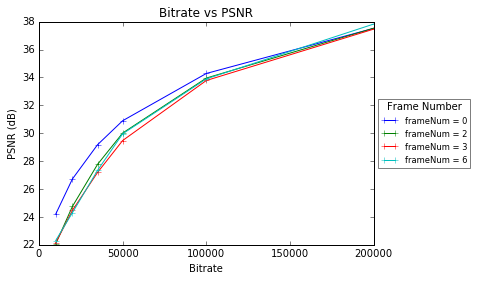

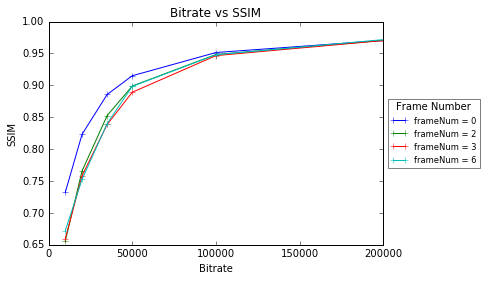

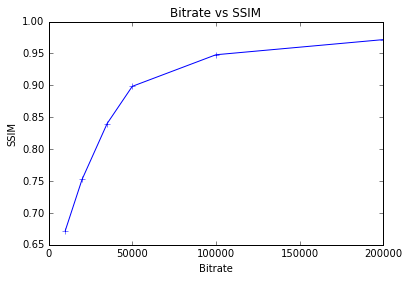

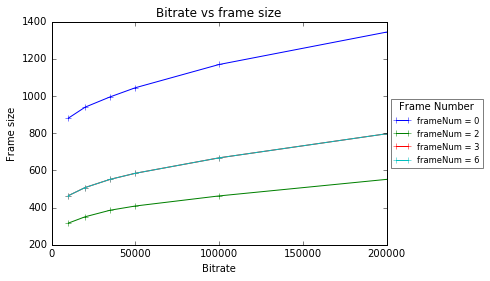

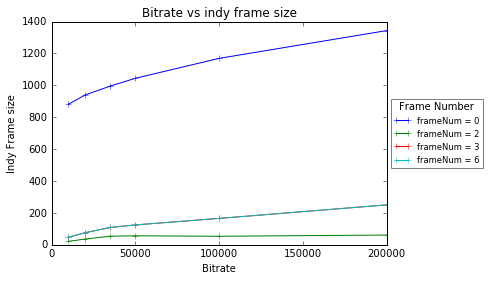

In [15]:
#print(qfEntries[0][0][3])

PSNRslot = 5
SSIMslot = 6
indyFrameSizeslot = 7
FrameSizeslot = 8


#print(qfEntries[0][0][0][5:8])
#temp = qfEntries[:][:][:][5:8]
#print(temp)


redQfEntries = np.asarray(qfEntries)

print("the new array shape {}".format(redQfEntries.shape))
print(redQfEntries[0][0][0])



qfEntriesMeans = np.mean(redQfEntries, axis=2)
print("the means array shape {}".format(qfEntriesMeans.shape))

    
#print("the means")
#print(qfEntriesMeans[0][0])
#for qIdx, quantValue in enumerate(quantValues):
#    for fIdx, frameNum in enumerate(frameNums):
#        print("qIdx {}, fIdx {}".format(qIdx, fIdx))
#        print("For quant {} and frame number {} means {:.2f} {:.2f} {:.2f}".format(quantValue, frameNum, qfEntriesMeans[qIdx][fIdx][0], qfEntriesMeans[qIdx][fIdx][1], qfEntriesMeans[qIdx][fIdx][2]))



fig1 = plt.figure()
for fIdx, frameNum in enumerate(frameNums):
    plt.xlabel('Bitrate')
    plt.ylabel('PSNR (dB)')
    plt.title('Bitrate vs PSNR')
    #averagePSNR = [48.16]
    #averageSSIM = [1.0]
    averagePSNR = []
    averageSSIM = []
    averageFrameSize = []
    averageIndyFrameSize = []
    for qIdx, quantValue in enumerate(quantValues):
        averagePSNR.append(qfEntriesMeans[qIdx][fIdx][0])
        averageSSIM.append(qfEntriesMeans[qIdx][fIdx][1])
        averageFrameSize.append(qfEntriesMeans[qIdx][fIdx][2])
        averageIndyFrameSize.append(qfEntriesMeans[qIdx][fIdx][3])
    #myQuants = [0] + quantValues
    myQuants = quantValues
    plt.plot( myQuants, averagePSNR, '-+', label=('frameNum = {}'.format(frameNum)))
plt.legend(title="Frame Number", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Bitrate_vs_PSNR.png', bbox_inches='tight')


fig2 = plt.figure()
for fIdx, frameNum in enumerate(frameNums):
    plt.xlabel('Bitrate')
    plt.ylabel('SSIM')
    plt.title('Bitrate vs SSIM')
    #averagePSNR = [48.16]
    #averageSSIM = [1.0]
    averagePSNR = []
    averageSSIM = []
    averageFrameSize = []
    averageIndyFrameSize = []
    for qIdx, quantValue in enumerate(quantValues):
        averagePSNR.append(qfEntriesMeans[qIdx][fIdx][0])
        averageSSIM.append(qfEntriesMeans[qIdx][fIdx][1])
        averageFrameSize.append(qfEntriesMeans[qIdx][fIdx][2])
        averageIndyFrameSize.append(qfEntriesMeans[qIdx][fIdx][3])
    #myQuants = [0] + quantValues
    myQuants = quantValues
    plt.plot( myQuants, averageSSIM, '-+', label=('frameNum = {}'.format(frameNum)))
plt.legend(title="Frame Number", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Bitrate_vs_SSIM.png', bbox_inches='tight')

fig2b = plt.figure()
frameNum = 0
plt.xlabel('Bitrate')
plt.ylabel('SSIM')
plt.title('Bitrate vs SSIM')
#averagePSNR = [48.16]
#averageSSIM = [1.0]
averagePSNR = []
averageSSIM = []
averageFrameSize = []
averageIndyFrameSize = []
for qIdx, quantValue in enumerate(quantValues):
    averagePSNR.append(qfEntriesMeans[qIdx][fIdx][0])
    averageSSIM.append(qfEntriesMeans[qIdx][fIdx][1])
    averageFrameSize.append(qfEntriesMeans[qIdx][fIdx][2])
    averageIndyFrameSize.append(qfEntriesMeans[qIdx][fIdx][3])
#myQuants = [0] + quantValues
myQuants = quantValues
plt.plot( myQuants, averageSSIM, '-+', label=('frameNum = {}'.format(frameNum)))
#plt.legend(title="Frame Number", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Bitrate_vs_SSIM_f0.png', bbox_inches='tight')

fig3 = plt.figure()
for fIdx, frameNum in enumerate(frameNums):
    plt.xlabel('Bitrate')
    plt.ylabel('Frame size')
    plt.title('Bitrate vs frame size')
    averagePSNR = []
    averageSSIM = []
    averageFrameSize = []
    averageIndyFrameSize = []
    for qIdx, quantValue in enumerate(quantValues):
        averagePSNR.append(qfEntriesMeans[qIdx][fIdx][0])
        averageSSIM.append(qfEntriesMeans[qIdx][fIdx][1])
        averageFrameSize.append(qfEntriesMeans[qIdx][fIdx][2])
        averageIndyFrameSize.append(qfEntriesMeans[qIdx][fIdx][3])
    plt.plot( quantValues, averageFrameSize, '-+', label=('frameNum = {}'.format(frameNum)))
plt.legend(title="Frame Number", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Bitrate_vs_frame_size.png', bbox_inches='tight')


fig4 = plt.figure()
for fIdx, frameNum in enumerate(frameNums):
    plt.xlabel('Bitrate')
    plt.ylabel('Indy Frame size')
    plt.title('Bitrate vs indy frame size')
    averagePSNR = []
    averageSSIM = []
    averageFrameSize = []
    averageIndyFrameSize = []
    for qIdx, quantValue in enumerate(quantValues):
        averagePSNR.append(qfEntriesMeans[qIdx][fIdx][0])
        averageSSIM.append(qfEntriesMeans[qIdx][fIdx][1])
        averageFrameSize.append(qfEntriesMeans[qIdx][fIdx][2])
        averageIndyFrameSize.append(qfEntriesMeans[qIdx][fIdx][3])
        print("Frameno: {} Quant: {} frameSize: {}".format(frameNum, quantValue, qfEntriesMeans[qIdx][fIdx][3]))
    plt.plot( quantValues, averageIndyFrameSize, '-+', label=('frameNum = {}'.format(frameNum)))
plt.legend(title="Frame Number", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Bitrate_vs_indy_frame_size.png', bbox_inches='tight')



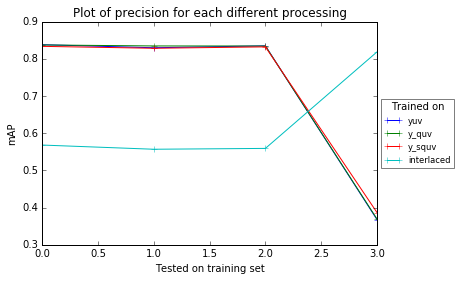

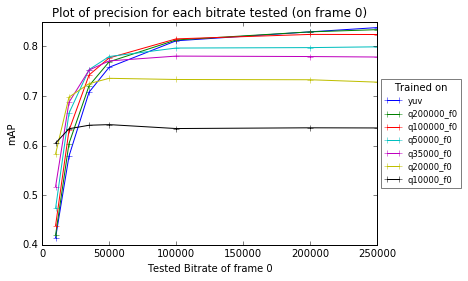

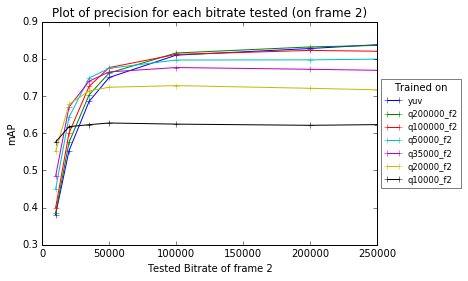

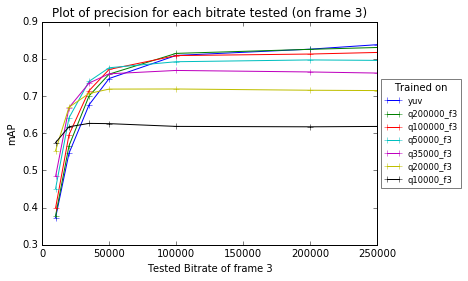

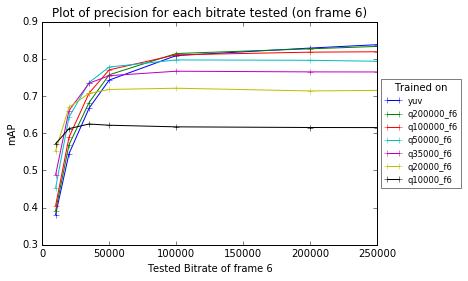

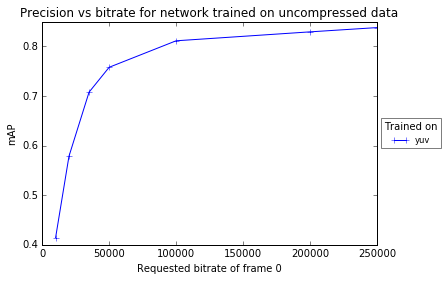

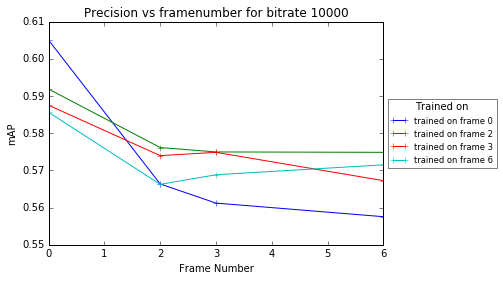

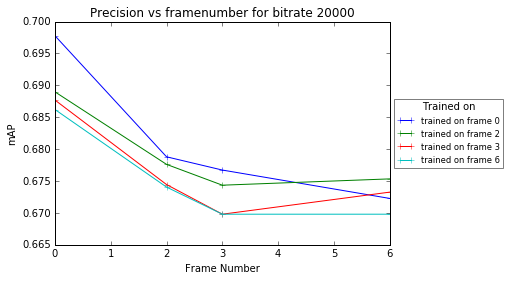

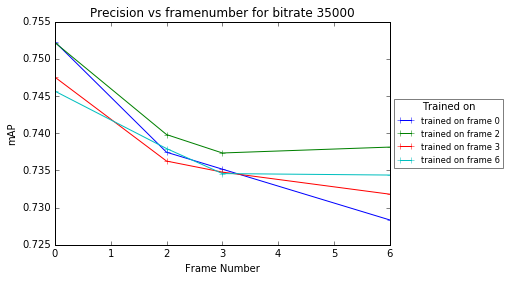

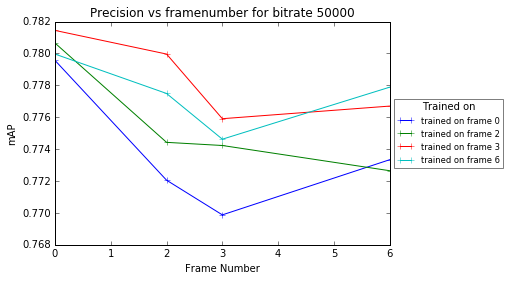

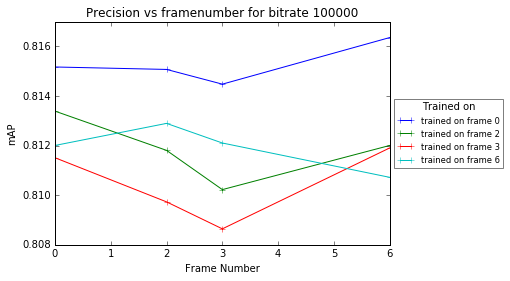

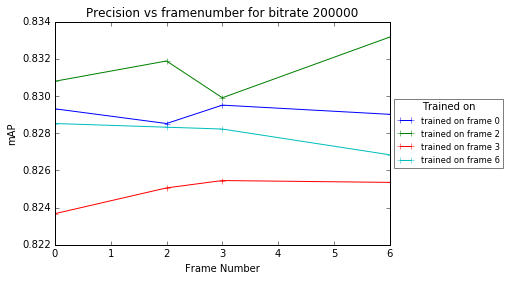

In [16]:
plotDataName = '/Volumes/LaCie/data/CIFAR-10/test4/log.txt'


with open(plotDataName, 'r') as f:
    allTheData = f.read()
    
textLines = allTheData.splitlines()
#trained, tested, result
dataArray = []
names = []
quants = [0]
maxBitrate = 250000

for line in textLines:
    #print("Begin")
    #print(line)
    words = line.split()
    if words[0] == 'Evaluating':
        trainedOn = words[3].split('-')
        trainedOn = trainedOn[0]
        testedOn = words[1]
        precision = words[-1]
        
        trainedQuant = maxBitrate
        trainedFrame = -1
        temp = list(trainedOn)
        if trainedQuant == 'yuv':
            trainedQuant = maxBitrate
        #print(temp)
        if temp[0] == 'q' and temp[1] != 'u':
            temp2 = trainedOn.split('_')
            temp2 = list(temp2[0])
            theNumbers = temp2[1:]
            theString = ''.join(theNumbers)
            trainedQuant = int(theString)
            if trainedQuant not in quants:
                quants.append(trainedQuant)
            frameGuess = trainedOn.split('_')
            frameGuess = list(frameGuess[1])
            if frameGuess[0] == 'f':
                trainedFrame = int(frameGuess[1])

        
        testedQuant = maxBitrate
        testedFrame = -1
        temp = list(testedOn)
        if testedOn == 'yuv':
            testedFrame = 0
        #print(temp)
        if temp[0] == 'q' and temp[1] != 'u':
            temp2 = testedOn.split('_')
            temp2 = list(temp2[0])
            if temp2[1] != 'u':
                theNumbers = temp2[1:]
                theString = ''.join(theNumbers)
                testedQuant = int(theString)
            else:
                testedQuant = maxBitrate
                testedFrame = -1
                
            frameGuess = testedOn.split('_')
            frameGuess = list(frameGuess[1])
            #print(frameGuess)
            if frameGuess[0] == 'f':
                testedFrame = int(frameGuess[1])


        
        dataEntry = [trainedOn, testedOn, trainedQuant, trainedFrame, testedQuant, testedFrame, precision]
        #print(dataEntry)
        dataArray.append(dataEntry)
        if trainedOn not in names:
            #print("adding: {}".format(trainedOn))
            names.append(trainedOn)
        
#print(names)
alternativeNames = names[0:4]
datasetNames = names
#print(alternativeNames)
fig0 = plt.figure()
plt.xlabel('Tested on training set'.format(frameNum))
plt.ylabel('mAP')
plt.title('Plot of precision for each different processing')
for nameIdx, name in enumerate(alternativeNames):
    plotVals = []
    quants = []
    for entry in dataArray:
        #print(entry)
        if entry[0] == name and entry[1] in alternativeNames:
            quants.append(entry[1])
            plotVals.append(entry[-1])
    #print(quants)
    
    plt.plot( np.arange(len(quants)), plotVals, '-+', label=(name))
plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('Quant_vs_mAP_types.png'.format(frameNum), bbox_inches='tight')


for fIdx, frameNum in enumerate(frameNums):
    fig1 = plt.figure()
    plt.xlabel('Tested Bitrate of frame {}'.format(frameNum))
    plt.ylabel('mAP')
    plt.title('Plot of precision for each bitrate tested (on frame {})'.format(frameNum))
    releventName = ('f{}'.format(frameNum))
    for nameIdx, name in enumerate(names):
        if releventName in name or name == 'yuv':
            #print(name)
            plotVals = []
            quants = []
            for entry in dataArray:
                if entry[0] == name and (entry[5] == frameNum or entry[1] == 'yuv'):
                    quants.append(entry[4])
                    plotVals.append(entry[-1])
            #plt.plot( np.arange(0, len(plotVals), 1), plotVals, label=(name))
            plt.plot( quants, plotVals, '-+', label=(name))
    plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('bitrate_vs_mAP_aug_f{}.png'.format(frameNum), bbox_inches='tight')
    
fig1b = plt.figure()
frameNum = 0
plt.xlabel('Requested bitrate of frame {}'.format(frameNum))
plt.ylabel('mAP')
plt.title('Precision vs bitrate for network trained on uncompressed data'.format(frameNum))
releventName = ('f{}'.format(frameNum))
name = 'yuv'
if releventName in name or name == 'yuv':
    #print(name)
    plotVals = []
    quants = []
    for entry in dataArray:
        if entry[0] == name and (entry[5] == frameNum or entry[1] == 'yuv'):
            quants.append(entry[4])
            plotVals.append(entry[-1])
    #plt.plot( np.arange(0, len(plotVals), 1), plotVals, label=(name))
    plt.plot( quants, plotVals, '-+', label=(name))
plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Bitrate_vs_mAP_aug_f{}_yuvOnly.png'.format(frameNum), bbox_inches='tight')

releventName = ('f{}'.format(frameNum))
names = ['q10000_', 'q20000_', 'q35000_', 'q50000_', 'q100000_', 'q200000_']
#print(name)
for name in names:
    fig1b = plt.figure()
    frameNums = [0, 2, 3, 6]
    correctedName = name.replace('_', '')
    correctedName = correctedName.replace('q', '')
    plt.xlabel('Frame Number')
    plt.ylabel('mAP')
    plt.title('Precision vs framenumber for bitrate {}'.format(correctedName))
    for frame in frameNums:
        plotVals = []
        quants = []
        for entry in dataArray:
            if name in entry[0] and name in entry[1] and entry[3] == frame:
                quants.append(entry[5])
                plotVals.append(entry[-1])
        plt.plot( quants, plotVals, '-+', label=("trained on frame {}".format(frame)))
    plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('Precision_vs_frameNo_forBitrate_.png'.format(correctedName), bbox_inches='tight')



Some SSIM, PSNR calculations...

In [17]:
# import the necessary packages
from skimage.measure import structural_similarity as structural_similarity
import matplotlib.pyplot as plt
import numpy as np
#import cv2

from ssim.ssimlib import SSIM
from ssim.ssimlib import SSIMImage
from ssim.ssimlib import get_gaussian_kernel
from ssim.compat import Image


def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension

    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    #print "the shape "
    #print np.shape(imageA)
    #print np.size(imageA)
    
    divider = np.prod(np.shape(imageA))
    #err /= float(np.shape(imageA)[0] * np.shape(imageA)[1])
    err /= float(divider)
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    if err < 1.0:
        err = 1.0
    return err

def psnr(imageA, imageB):
    myMSE = mse(imageA, imageB)
    #print ("mse = {}".format(myMSE))
    temp = 255 / (np.sqrt(myMSE))
    psnr = 20 * np.log10(temp)
    return psnr

def ssim(imageA, imageB):
    gaussian_kernel_sigma=1.5
    gaussian_kernel_width=11
    gaussian_kernel_1d = get_gaussian_kernel(gaussian_kernel_width, gaussian_kernel_sigma)
    return SSIM(imageA, gaussian_kernel_1d).ssim_value(imageB)

def comparisonMetrics_yuvBuffers(dataA, dataB, width, height, verbose = False):
    if verbose:
        print("************Comparison Metrics************")
            #print("The shape of dataA {}".format(dataA.shape))
    test = np.asarray(np.ndarray.flatten(dataA), 'u1')
    pictureA = test.reshape(3, width, height)
    pictureA = np.swapaxes(pictureA,0,1)
    pictureA = np.swapaxes(pictureA,1,2)
    pictureA = np.ndarray.flatten(pictureA)
    imageA = Image.frombytes('RGB', (width, height), pictureA)
    test = np.array(list(imageA.getdata()))
    #print("The shape of the test {} and the data {}".format(test.shape, test))


    #print("The shape of dataB {}".format(dataB.shape))
    test = np.asarray(np.ndarray.flatten(dataB), 'u1')
    pictureB = test.reshape(3, width, height)
    pictureB = np.swapaxes(pictureB,0,1)
    pictureB = np.swapaxes(pictureB,1,2)
    pictureB = np.ndarray.flatten(pictureB)
    imageB = Image.frombytes('RGB', (width, height), pictureB)
    test = np.array(list(imageB.getdata()))
    #print("The shape of the test {} and the data {}".format(test.shape, test))

    #m = mse(dataA, dataB)
    m = psnr(dataA, dataB)
    s = ssim(imageA, imageB)
    return (m, s)

In [19]:
#print(datasetNames)
redDatasetNames = datasetNames

redDatasetNames = [ x for x in redDatasetNames if "f2" not in x ]
redDatasetNames = [ x for x in redDatasetNames if "f3" not in x ]
redDatasetNames = [ x for x in redDatasetNames if "f6" not in x ]
#print(redDatasetNames)



PSNR_SSIM_results = []
for baseName in redDatasetNames:
    for compName in redDatasetNames:
        
        if baseName == compName:
            PSNR_SSIM_results.append([baseName, compName, 48.2, 1.0])
            continue

        
        basedatadir = '/Volumes/LaCie/data/CIFAR-10/cifar_data_constantBitrate/cifar-10-batches-bin_'+ baseName + '/'
        compdatadir = '/Volumes/LaCie/data/CIFAR-10/cifar_data_constantBitrate/cifar-10-batches-bin_' + compName + '/'
        binfileNames = ['data_batch_1.bin']
        
        print("Comparing {} and {}".format(baseName, compName))

        #binfileNames = ['data_batch_1.bin', 'data_batch_2.bin', 'data_batch_3.bin', 'data_batch_4.bin', 'data_batch_5.bin', 'test_batch.bin']
        width = 32
        height  = 32
        channels = 3
        recordSize = (width * height * channels) + 1

        mTotal = 0
        sTotal = 0

        for binfileName in binfileNames:
            name_base = basedatadir + binfileName
            name_comp = compdatadir + binfileName

            f_base = open(name_base, "rb")
            allTheData_base = np.fromfile(f_base, 'u1')
            cases_base = allTheData_base.shape[0] / recordSize

            allTheData_base = allTheData_base.reshape(cases_base, recordSize)
            data_labels_base = allTheData_base[:, 0].copy()
            data_array_base = allTheData_base[:, 1:].copy()
            data_array_base = data_array_base * 8

            
            print(data_array_base.shape)


            f_comp = open(name_comp, "rb")
            allTheData_comp = np.fromfile(f_comp, 'u1')
            cases_comp = allTheData_comp.shape[0] / recordSize

            allTheData_comp = allTheData_comp.reshape(cases_comp, recordSize)
            data_labels_comp = allTheData_comp[:, 0].copy()
            data_array_comp = allTheData_comp[:, 1:].copy()
            data_array_comp = data_array_comp * 8

            if data_labels_base.all() != data_labels_comp.all():
                print("Warning, the labels aren't the same!")

            #frame = data_array_base[0]
            #rgbframe = planarYUV_2_planarRGB(frame, 32, 32)
            #display_image_rgb(rgbframe, 32, 32)                
            #frame = data_array_comp[0]
            #rgbframe = planarYUV_2_planarRGB(frame, 32, 32)
            #display_image_rgb(rgbframe, 32, 32)                


            mTotalBinFile = 0
            sTotalBinFile = 0
            for idx, entry in enumerate(data_array_base):
                #print("Shape of entry{}".format(entry.shape))
                
                #if idx > 10:
                #    break
                m, s = comparisonMetrics_yuvBuffers(data_array_base[idx], data_array_comp[idx], 32, 32)
                #print("PSNR: {} SSIM: {}".format(m, s))
                #frame = data_array_base[idx]
                #rgbframe = planarYUV_2_planarRGB(frame, 32, 32)
                #display_image_rgb(rgbframe, 32, 32)                
                #frame = data_array_comp[idx]
                #rgbframe = planarYUV_2_planarRGB(frame, 32, 32)
                #display_image_rgb(rgbframe, 32, 32)                

                
                mTotalBinFile = mTotalBinFile + m
                sTotalBinFile = sTotalBinFile + s

            
            
            avg_m = mTotalBinFile / cases_base
            avg_s = sTotalBinFile / cases_base
            mTotal = mTotal + avg_m
            sTotal = sTotal + avg_s

        numBinFiles = len(binfileNames)
        avg_m = mTotal / numBinFiles
        avg_s = sTotal / numBinFiles

        print("For {} vs {} Average mse {} SSIM {}".format(baseName, compName, avg_m, avg_s))
        PSNR_SSIM_results.append([baseName, compName, avg_m, avg_s])

Comparing yuv and y_quv
(10000, 3072)
For yuv vs y_quv Average mse 30.4301053597 SSIM 0.942584396443
Comparing yuv and y_squv
(10000, 3072)
For yuv vs y_squv Average mse 39.1039869198 SSIM 0.972508976904
Comparing yuv and interlaced
(10000, 3072)
For yuv vs interlaced Average mse 22.4232731275 SSIM 0.75476240455
Comparing yuv and q200000_f0
(10000, 3072)
For yuv vs q200000_f0 Average mse 35.0402968799 SSIM 0.949116023587
Comparing yuv and q100000_f0
(10000, 3072)
For yuv vs q100000_f0 Average mse 32.8548095135 SSIM 0.929881781459
Comparing yuv and q50000_f0
(10000, 3072)
For yuv vs q50000_f0 Average mse 30.1551387883 SSIM 0.893785625405
Comparing yuv and q35000_f0
(10000, 3072)
For yuv vs q35000_f0 Average mse 28.6492572888 SSIM 0.864950976985
Comparing yuv and q20000_f0
(10000, 3072)
For yuv vs q20000_f0 Average mse 26.4136742954 SSIM 0.804162412444
Comparing yuv and q10000_f0
(10000, 3072)
For yuv vs q10000_f0 Average mse 24.021517535 SSIM 0.714704661196
Comparing y_quv and yuv
(1000

Plot some graphs

['q10000_', 'q20000_', 'q35000_', 'q50000_', 'q100000_', 'q200000_']
['yuv', 'y_quv', 'y_squv', 'interlaced', 'q200000_f0', 'q100000_f0', 'q50000_f0', 'q35000_f0', 'q20000_f0', 'q10000_f0']
yuv
Trained yuv tested yuv SSIM 1.0 mAP 0.837915348101
Trained yuv tested q200000_f0 SSIM 0.949116023587 mAP 0.829311708861
Trained yuv tested q100000_f0 SSIM 0.929881781459 mAP 0.811313291139
Trained yuv tested q50000_f0 SSIM 0.893785625405 mAP 0.757911392405
Trained yuv tested q35000_f0 SSIM 0.864950976985 mAP 0.707772943038
Trained yuv tested q20000_f0 SSIM 0.804162412444 mAP 0.578619462025
Trained yuv tested q10000_f0 SSIM 0.714704661196 mAP 0.414359177215
q200000_f0
Trained q200000_f0 tested yuv SSIM 0.949116023587 mAP 0.833761867089
Trained q200000_f0 tested q200000_f0 SSIM 1.0 mAP 0.829311708861
Trained q200000_f0 tested q100000_f0 SSIM 0.945303251689 mAP 0.812994462025
Trained q200000_f0 tested q50000_f0 SSIM 0.907777427787 mAP 0.768987341772
Trained q200000_f0 tested q35000_f0 SSIM 0.876419

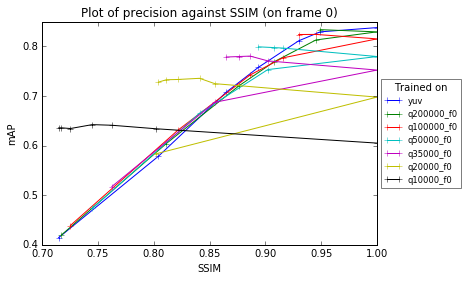

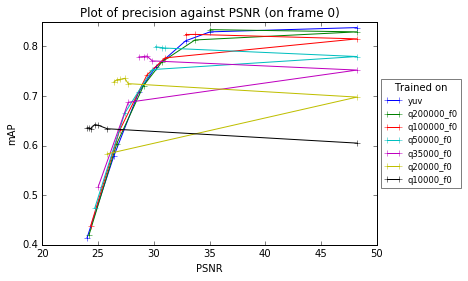

In [16]:
#print(PSNR_SSIM_results)

frameNum = 0
fig1 = plt.figure()
plt.xlabel('SSIM')
plt.ylabel('mAP')
plt.title('Plot of precision against SSIM (on frame {})'.format(frameNum))
releventName = ('f{}'.format(frameNum))
print(names)
print(redDatasetNames)
for nameIdx, name in enumerate(redDatasetNames):
    if releventName in name or name == 'yuv':
        print(name)
        plotVals = []
        SSIMs = []
        for entry in dataArray:
            if entry[0] == name and (entry[5] == frameNum or entry[1] == 'yuv'):
                quant = entry[4]
                plotVals.append(entry[-1])
                for result in PSNR_SSIM_results:
                    if result[0] == name and result[1] == entry[1]:
                        SSIMs.append(result[-1])
                        ssim = result[-1]
                        break
                # pretty print
                print("Trained {} tested {} SSIM {} mAP {}".format(name, entry[1], ssim, entry[-1]))

        #plt.plot( np.arange(0, len(plotVals), 1), plotVals, label=(name))
        plt.plot( SSIMs, plotVals, '-+', label=(name))
        
plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('SSIM_vs_Precision.png'.format(frameNum), bbox_inches='tight')

frameNum = 0
fig1 = plt.figure()
plt.xlabel('PSNR')
plt.ylabel('mAP')
plt.title('Plot of precision against PSNR (on frame {})'.format(frameNum))
releventName = ('f{}'.format(frameNum))
for nameIdx, name in enumerate(redDatasetNames):
    if releventName in name or name == 'yuv':
        print(name)
        plotVals = []
        PSNRs = []
        for entry in dataArray:
            if entry[0] == name and (entry[5] == frameNum or entry[1] == 'yuv'):
                quant = entry[4]
                plotVals.append(entry[-1])
                for result in PSNR_SSIM_results:
                    if result[0] == name and result[1] == entry[1]:
                        PSNRs.append(result[-2])
        #plt.plot( np.arange(0, len(plotVals), 1), plotVals, label=(name))
        plt.plot( PSNRs, plotVals, '-+', label=(name))
plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('PSNR_vs_Precision.png'.format(frameNum), bbox_inches='tight')



yuv
Trained yuv tested yuv SSIM 1.0 mAP 0.837915348101
Trained yuv tested q200000_f0 SSIM 0.949116023587 mAP 0.829311708861
Trained yuv tested q100000_f0 SSIM 0.929881781459 mAP 0.811313291139
Trained yuv tested q50000_f0 SSIM 0.893785625405 mAP 0.757911392405
Trained yuv tested q35000_f0 SSIM 0.864950976985 mAP 0.707772943038
Trained yuv tested q20000_f0 SSIM 0.804162412444 mAP 0.578619462025
Trained yuv tested q10000_f0 SSIM 0.714704661196 mAP 0.414359177215
q200000_f0
Trained q200000_f0 tested yuv SSIM 1.0 mAP 0.833761867089
Trained q200000_f0 tested q200000_f0 SSIM 0.949116023587 mAP 0.829311708861
Trained q200000_f0 tested q100000_f0 SSIM 0.929881781459 mAP 0.812994462025
Trained q200000_f0 tested q50000_f0 SSIM 0.893785625405 mAP 0.768987341772
Trained q200000_f0 tested q35000_f0 SSIM 0.864950976985 mAP 0.720727848101
Trained q200000_f0 tested q20000_f0 SSIM 0.804162412444 mAP 0.604232594937
Trained q200000_f0 tested q10000_f0 SSIM 0.714704661196 mAP 0.419699367089
q100000_f0
Tra

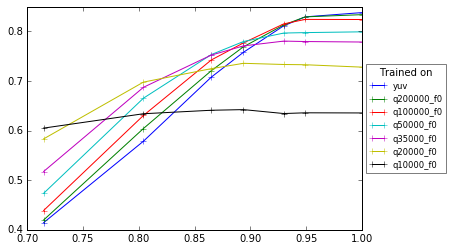

In [17]:
for nameIdx, name in enumerate(redDatasetNames):
    if releventName in name or name == 'yuv':
        print(name)
        plotVals = []
        SSIMs = []
        for entry in dataArray:
            if entry[0] == name and (entry[5] == frameNum or entry[1] == 'yuv'):
                quant = entry[4]
                plotVals.append(entry[-1])
                for result in PSNR_SSIM_results:
                    if result[0] == 'yuv' and result[1] == entry[1]:
                        SSIMs.append(result[-1])
                        ssim = result[-1]
                        break
                # pretty print
                print("Trained {} tested {} SSIM {} mAP {}".format(name, entry[1], ssim, entry[-1]))

        #plt.plot( np.arange(0, len(plotVals), 1), plotVals, label=(name))
        plt.plot( SSIMs, plotVals, '-+', label=(name))
        
plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('SSIM(uncompressed)_vs_Precision.png'.format(frameNum), bbox_inches='tight')



Repeating the above for constant quant, full augmentation

['yuv', 'y_quv', 'y_squv', 'interlaced', 'q10_f0', 'q10_f2', 'q10_f3', 'q10_f6', 'q25_f0', 'q25_f2', 'q25_f3', 'q25_f6', 'q37_f0', 'q37_f2', 'q37_f3', 'q37_f6', 'q41_f0', 'q41_f2', 'q41_f3', 'q41_f6', 'q46_f0', 'q46_f2', 'q46_f3', 'q46_f6', 'q50_f0', 'q50_f2', 'q50_f3', 'q50_f6']
Comparing yuv and y_quv
(10000, 3072)
For yuv vs y_quv Average mse 30.4301053597 SSIM 0.942584396443
Comparing yuv and y_squv
(10000, 3072)
For yuv vs y_squv Average mse 39.1039869198 SSIM 0.972508976904
Comparing yuv and interlaced
(10000, 3072)
For yuv vs interlaced Average mse 22.4232731275 SSIM 0.75476240455
Comparing yuv and q10_f0
(10000, 3072)
For yuv vs q10_f0 Average mse 38.2063516746 SSIM 0.968514964466
Comparing yuv and q25_f0
(10000, 3072)
For yuv vs q25_f0 Average mse 34.9406402684 SSIM 0.948390947121
Comparing yuv and q37_f0
(10000, 3072)
For yuv vs q37_f0 Average mse 30.1906123909 SSIM 0.895089335655
Comparing yuv and q41_f0
(10000, 3072)
For yuv vs q41_f0 Average mse 28.2431457597 SSIM 0.857077

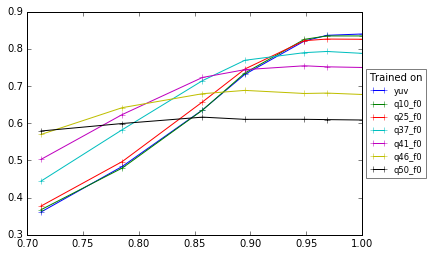

In [15]:
plotDataName = '/Users/pam/Documents/data/CIFAR-10/test3/log.txt'


with open(plotDataName, 'r') as f:
    allTheData = f.read()
    
textLines = allTheData.splitlines()
#trained, tested, result
dataArray = []
names = []
quants = [0]
maxBitrate = 250000

for line in textLines:
    #print("Begin")
    #print(line)
    words = line.split()
    if words[0] == 'Evaluating':
        trainedOn = words[3].split('-')
        trainedOn = trainedOn[0]
        testedOn = words[1]
        precision = words[-1]
        
        trainedQuant = maxBitrate
        trainedFrame = -1
        temp = list(trainedOn)
        if trainedQuant == 'yuv':
            trainedQuant = maxBitrate
        #print(temp)
        if temp[0] == 'q' and temp[1] != 'u':
            temp2 = trainedOn.split('_')
            temp2 = list(temp2[0])
            theNumbers = temp2[1:]
            theString = ''.join(theNumbers)
            trainedQuant = int(theString)
            if trainedQuant not in quants:
                quants.append(trainedQuant)
            frameGuess = trainedOn.split('_')
            frameGuess = list(frameGuess[1])
            if frameGuess[0] == 'f':
                trainedFrame = int(frameGuess[1])

        
        testedQuant = maxBitrate
        testedFrame = -1
        temp = list(testedOn)
        if testedOn == 'yuv':
            testedFrame = 0
        #print(temp)
        if temp[0] == 'q' and temp[1] != 'u':
            temp2 = testedOn.split('_')
            temp2 = list(temp2[0])
            if temp2[1] != 'u':
                theNumbers = temp2[1:]
                theString = ''.join(theNumbers)
                testedQuant = int(theString)
            else:
                testedQuant = maxBitrate
                testedFrame = -1
                
            frameGuess = testedOn.split('_')
            frameGuess = list(frameGuess[1])
            #print(frameGuess)
            if frameGuess[0] == 'f':
                testedFrame = int(frameGuess[1])


        
        dataEntry = [trainedOn, testedOn, trainedQuant, trainedFrame, testedQuant, testedFrame, precision]
        #print(dataEntry)
        dataArray.append(dataEntry)
        if trainedOn not in names:
            #print("adding: {}".format(trainedOn))
            names.append(trainedOn)
        
print(names)
alternativeNames = names[0:4]
datasetNames = names
#print(alternativeNames)

#print(datasetNames)
redDatasetNames = datasetNames

redDatasetNames = [ x for x in redDatasetNames if "f2" not in x ]
redDatasetNames = [ x for x in redDatasetNames if "f3" not in x ]
redDatasetNames = [ x for x in redDatasetNames if "f6" not in x ]
#print(redDatasetNames)



PSNR_SSIM_results = []
for baseName in redDatasetNames:
    for compName in redDatasetNames:
        
        if baseName == compName:
            PSNR_SSIM_results.append([baseName, compName, 48.2, 1.0])
            continue

        
        basedatadir = '/Users/pam/Documents/data/CIFAR-10/cifar_data_constantQuant/cifar-10-batches-bin_'+ baseName + '/'
        compdatadir = '/Users/pam/Documents/data/CIFAR-10/cifar_data_constantQuant/cifar-10-batches-bin_' + compName + '/'
        binfileNames = ['data_batch_1.bin']
        
        print("Comparing {} and {}".format(baseName, compName))

        #binfileNames = ['data_batch_1.bin', 'data_batch_2.bin', 'data_batch_3.bin', 'data_batch_4.bin', 'data_batch_5.bin', 'test_batch.bin']
        width = 32
        height  = 32
        channels = 3
        recordSize = (width * height * channels) + 1

        mTotal = 0
        sTotal = 0

        for binfileName in binfileNames:
            name_base = basedatadir + binfileName
            name_comp = compdatadir + binfileName

            f_base = open(name_base, "rb")
            allTheData_base = np.fromfile(f_base, 'u1')
            cases_base = allTheData_base.shape[0] / recordSize

            allTheData_base = allTheData_base.reshape(cases_base, recordSize)
            data_labels_base = allTheData_base[:, 0].copy()
            data_array_base = allTheData_base[:, 1:].copy()
            data_array_base = data_array_base * 8

            
            print(data_array_base.shape)


            f_comp = open(name_comp, "rb")
            allTheData_comp = np.fromfile(f_comp, 'u1')
            cases_comp = allTheData_comp.shape[0] / recordSize

            allTheData_comp = allTheData_comp.reshape(cases_comp, recordSize)
            data_labels_comp = allTheData_comp[:, 0].copy()
            data_array_comp = allTheData_comp[:, 1:].copy()
            data_array_comp = data_array_comp * 8

            if data_labels_base.all() != data_labels_comp.all():
                print("Warning, the labels aren't the same!")

            #frame = data_array_base[0]
            #rgbframe = planarYUV_2_planarRGB(frame, 32, 32)
            #display_image_rgb(rgbframe, 32, 32)                
            #frame = data_array_comp[0]
            #rgbframe = planarYUV_2_planarRGB(frame, 32, 32)
            #display_image_rgb(rgbframe, 32, 32)                


            mTotalBinFile = 0
            sTotalBinFile = 0
            for idx, entry in enumerate(data_array_base):
                #print("Shape of entry{}".format(entry.shape))
                
                #if idx > 10:
                #    break
                m, s = comparisonMetrics_yuvBuffers(data_array_base[idx], data_array_comp[idx], 32, 32)
                #print("PSNR: {} SSIM: {}".format(m, s))
                #frame = data_array_base[idx]
                #rgbframe = planarYUV_2_planarRGB(frame, 32, 32)
                #display_image_rgb(rgbframe, 32, 32)                
                #frame = data_array_comp[idx]
                #rgbframe = planarYUV_2_planarRGB(frame, 32, 32)
                #display_image_rgb(rgbframe, 32, 32)                

                
                mTotalBinFile = mTotalBinFile + m
                sTotalBinFile = sTotalBinFile + s

            
            
            avg_m = mTotalBinFile / cases_base
            avg_s = sTotalBinFile / cases_base
            mTotal = mTotal + avg_m
            sTotal = sTotal + avg_s

        numBinFiles = len(binfileNames)
        avg_m = mTotal / numBinFiles
        avg_s = sTotal / numBinFiles

        print("For {} vs {} Average mse {} SSIM {}".format(baseName, compName, avg_m, avg_s))
        PSNR_SSIM_results.append([baseName, compName, avg_m, avg_s])

for nameIdx, name in enumerate(redDatasetNames):
    if releventName in name or name == 'yuv':
        print(name)
        plotVals = []
        SSIMs = []
        for entry in dataArray:
            if entry[0] == name and (entry[5] == frameNum or entry[1] == 'yuv'):
                quant = entry[4]
                plotVals.append(entry[-1])
                for result in PSNR_SSIM_results:
                    if result[0] == 'yuv' and result[1] == entry[1]:
                        SSIMs.append(result[-1])
                        ssim = result[-1]
                        break
                # pretty print
                print("Trained {} tested {} SSIM {} mAP {}".format(name, entry[1], ssim, entry[-1]))

        #plt.plot( np.arange(0, len(plotVals), 1), plotVals, label=(name))
        plt.plot( SSIMs, plotVals, '-+', label=(name))
        
plt.legend(title="Trained on", fontsize='small', framealpha=0.5, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('SSIM(uncompressed)_vs_Precision.png'.format(frameNum), bbox_inches='tight')


-----------
STOP STOP STOP
-------------
below here is just the old notMNIST stuff from the Udacity short course.

In [ ]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    print(set_filename)
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names


print("*********")
print(train_folders_o)
print("*********")

train_datasets_o = maybe_pickle(train_folders_o, 45000)
test_datasets_o = maybe_pickle(test_folders_o, 1800)

num = len(train_folders_m)
print("*********")
print(num)
print("*********")
train_datasets_m = []
test_datasets_m = []
for x in range(0, num):
    print(train_folders_m[x])
    print("*********")

    train_datasets_m.append( maybe_pickle(train_folders_m[x], 45000))
    test_datasets_m.append( maybe_pickle(test_folders_m[x], 1800))


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [ ]:
import pickle

selectdatasets = [train_datasets_o, test_datasets_o]

for datasets in selectdatasets:
    mydataA = pickle.load( open( datasets[0], "rb" ) )
    mydataB = pickle.load( open( datasets[1], "rb" ) )
    mydataC = pickle.load( open( datasets[2], "rb" ) )

    mydata = np.concatenate((mydataA, mydataB, mydataC), axis=0)
    mydataShape = mydata.shape
    import random
    letter = random.randint(0,mydataShape[0])
    import matplotlib.pyplot as plt
    plt.imshow(mydata[letter])
    plt.show()
    
selectdatasets = [train_datasets_m, test_datasets_m]

num = len(train_folders_m)

for datasets in selectdatasets:
    num = random.randint(0,8)
    mydataA = pickle.load( open( datasets[num][0], "rb" ) )
    mydataB = pickle.load( open( datasets[num][1], "rb" ) )
    mydataC = pickle.load( open( datasets[num][2], "rb" ) )

    mydata = np.concatenate((mydataA, mydataB, mydataC), axis=0)
    mydataShape = mydata.shape
    import random
    letter = random.randint(0,mydataShape[0])
    import matplotlib.pyplot as plt
    plt.imshow(mydata[letter])
    plt.show()    

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [ ]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000


valid_dataset_o, valid_labels_o, train_dataset_o, train_labels_o = merge_datasets(train_datasets_o, train_size, valid_size)
_, _, test_dataset_o, test_labels_o = merge_datasets(test_datasets_o, test_size)
#_, _, test_dataset2, test_labels2 = merge_datasets(test_datasets2, test_size2)

num = len(train_folders_m)
valid_dataset_m = []
valid_labels_m = []
train_dataset_m = []
train_labels_m = []
test_dataset_m = []
test_labels_m = []

for x in range(0, num):
    valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets_m[x], train_size, valid_size)
    valid_dataset_m.append(valid_dataset)
    valid_labels_m.append(valid_labels)
    train_dataset_m.append(train_dataset)
    train_labels_m.append(train_labels)
    _, _, test_dataset, test_labels = merge_datasets(test_datasets_m[x], test_size)
    test_dataset_m.append(test_dataset)
    test_labels_m.append(test_labels)

    


print('Training:', train_dataset_o.shape, train_labels_o.shape)
print('Validation:', valid_dataset_o.shape, valid_labels_o.shape)
print('Testing:', test_dataset_o.shape, test_labels_o.shape)

for x in range(0, num):
    print('Training:', train_dataset_m[x].shape, train_labels_m[x].shape)
    print('Validation:', valid_dataset_m[x].shape, valid_labels_m[x].shape)
    print('Testing:', test_dataset_m[x].shape, test_labels_m[x].shape)





Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [ ]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset_o, train_labels_o = randomize(train_dataset_o, train_labels_o)
test_dataset_o, test_labels_o = randomize(test_dataset_o, test_labels_o)
valid_dataset_o, valid_labels_o = randomize(valid_dataset_o, valid_labels_o)

for x in range(0, num):
    train_dataset_m[x], train_labels_m[x] = randomize(train_dataset_m[x], train_labels_m[x])
    test_dataset_m[x], test_labels_m[x] = randomize(test_dataset_m[x], test_labels_m[x])
    valid_dataset_m[x], valid_labels_m[x] = randomize(valid_dataset_m[x], valid_labels_m[x])


---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [ ]:
letterArray = np.array(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"])

pairs = [(train_dataset_o, train_labels_o), (test_dataset_o, test_labels_o)]

for x in range(0, num):
    pairs.append((train_dataset_m[x], train_labels_m[x]))
    pairs.append((test_dataset_m[x], test_labels_m[x]))


for pair in pairs:
    dataset = pair[0]
    labels = pair[1]
    mydataShape = dataset.shape

    sample = random.randint(0,mydataShape[0])

    print('Sample:', sample, 'Letter label:', letterArray[labels[sample]])

    plt.imshow(dataset[sample])
    plt.show()

Finally, let's save the data for later reuse:

In [ ]:
pickle_file = 'notMNIST_orig.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_o,
    'train_labels': train_labels_o,
    'valid_dataset': valid_dataset_o,
    'valid_labels': valid_labels_o,
    'test_dataset': test_dataset_o,
    'test_labels': test_labels_o,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)


for x in range(0, num):
    pickle_file = 'notMNIST_compressed_{}.pickle'.format(x)
    
    print(pickle_file)

    try:
      f = open(pickle_file, 'wb')
      save = {
        'train_dataset': train_dataset_m[x],
        'train_labels': train_labels_m[x],
        'valid_dataset': valid_dataset_m[x],
        'valid_labels': valid_labels_m[x],
        'test_dataset': test_dataset_m[x],
        'test_labels': test_labels_m[x],
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise
    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:', statinfo.st_size)


    

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [ ]:
import time
import hashlib

def cleanData (train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels):
    train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
    valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
    test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

    valid_in_train = np.in1d(valid_hashes, train_hashes)
    test_in_train  = np.in1d(test_hashes,  train_hashes)
    test_in_valid  = np.in1d(test_hashes,  valid_hashes)

    valid_keep = ~valid_in_train
    test_keep  = ~(test_in_train | test_in_valid)

    valid_dataset_clean = valid_dataset[valid_keep]
    valid_labels_clean  = valid_labels [valid_keep]

    test_dataset_clean = test_dataset[test_keep]
    test_labels_clean  = test_labels [test_keep]
    return valid_dataset_clean, valid_labels_clean, test_dataset_clean, test_labels_clean, valid_in_train, test_in_train, test_in_valid

valid_dataset_clean_o, valid_labels_clean_o, test_dataset_clean_o, test_labels_clean_o, valid_in_train, test_in_train, test_in_valid = cleanData(train_dataset_o, train_labels_o, valid_dataset_o, valid_labels_o, test_dataset_o, test_labels_o)
pickle_file = 'notMNIST_orig_clean.pickle'
try:
  f = open(pickle_file, 'wb')
  save = {
    'valid_dataset': valid_dataset_clean_o,
    'valid_labels': valid_labels_clean_o,
    'test_dataset': test_dataset_clean_o,
    'test_labels': test_labels_clean_o,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
statinfo = os.stat(pickle_file)
print('Compressed cleaned pickle size:', statinfo.st_size)

print("valid -> train overlap: %d samples" % valid_in_train.sum())
print("test  -> train overlap: %d samples" % test_in_train.sum())
print("test  -> valid overlap: %d samples" % test_in_valid.sum())

for x in range(0, num):
    valid_dataset_clean_m, valid_labels_clean_m, test_dataset_clean_m, test_labels_clean_m, valid_in_train, test_in_train, test_in_valid = cleanData(train_dataset_m[x], train_labels_m[x], valid_dataset_m[x], valid_labels_m[x], test_dataset_m[x], test_labels_m[x])

    pickle_file = 'notMNIST_compressed_clean_{}.pickle'.format(x)
    
    print(pickle_file)

    try:
      f = open(pickle_file, 'wb')
      save = {
        'valid_dataset': valid_dataset_clean_m,
        'valid_labels': valid_labels_clean_m,
        'test_dataset': test_dataset_clean_m,
        'test_labels': test_labels_clean_m,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise
    statinfo = os.stat(pickle_file)
    print('Compressed cleaned pickle size:', statinfo.st_size)
    
    print("valid -> train overlap: %d samples" % valid_in_train.sum())
    print("test  -> train overlap: %d samples" % test_in_train.sum())
    print("test  -> valid overlap: %d samples" % test_in_valid.sum())



---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [ ]:
train_set_size = 500
red_train_dataset_pic = train_dataset_o[0:train_set_size]
#rejig it so that it's just samples and xy, so size (samples, 28x28)
red_train_dataset = red_train_dataset_pic.reshape(train_set_size, (28*28))
red_train_labels = train_labels_o[0:train_set_size]
print('Reduced Training:', red_train_dataset.shape, red_train_labels.shape)
test_set_size = 10
red_test_dataset_pic = test_dataset_o[0:test_set_size]
red_test_dataset = red_test_dataset_pic.reshape(test_set_size, (28*28))
red_test_labels = test_labels_o[0:test_set_size]
print('Reduced test:', red_test_dataset.shape, red_test_labels.shape)

test_set_size2 = 10
selected_compressed = 2
red_test_dataset_pic2 = test_dataset_m[selected_compressed][0:test_set_size2]
red_test_dataset2 = red_test_dataset_pic2.reshape(test_set_size2, (28*28))
red_test_labels2 = test_labels_m[selected_compressed][0:test_set_size2]
print('Reduced test 2:', red_test_dataset2.shape, red_test_labels2.shape)


regr = LogisticRegression()
regr.fit(red_train_dataset, red_train_labels)
myScore = regr.score(red_test_dataset, red_test_labels)

print('Model score:', myScore)

myResults = regr.predict(red_test_dataset)
for index in range(len(myResults)):
    if (myResults[index] != red_test_labels[index]):
        print('Sample', index, 'Predicted label', letterArray[myResults[index]], 'Actual label', letterArray[red_test_labels[index]])
        plt.imshow(red_test_dataset_pic[index])
        plt.show()
        
print('And the compressed test set:')
myResults = regr.predict(red_test_dataset2)
for index in range(len(myResults)):
    if (myResults[index] != red_test_labels2[index]):
        print('Sample (compressed)', index, 'Predicted label', letterArray[myResults[index]], 'Actual label', letterArray[red_test_labels2[index]])
        plt.imshow(red_test_dataset_pic2[index])
        plt.show()

